## Data preprocessing

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# === Load and preprocess energy data ===
df = pd.read_csv("mm79158.csv", sep=';', decimal=',')
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

# Resample to 30-minute intervals and interpolate
df_resampled = df.resample('30min').mean()
df_resampled['vrednost'] = df_resampled['vrednost'].interpolate(method='time')

# Extract time-based features
df_resampled['hour_48'] = df_resampled.index.map(lambda x: (x.hour * 2 + x.minute // 30) + 1)
df_resampled['day_of_week'] = df_resampled.index.dayofweek

# === Load holidays and tag rows ===
holidays = pd.read_csv("slovenian_holidays_2016_2018.csv")
holidays['holiday_date'] = pd.to_datetime(holidays['holiday_date'])
holiday_set = set(holidays['holiday_date'].dt.normalize())
df_resampled['is_holiday'] = df_resampled.index.normalize().isin(holiday_set).astype(int)

# === One-hot encode hour_48, day_of_week, and is_holiday ===
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df_resampled[['hour_48', 'day_of_week', 'is_holiday']])
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(['hour_48', 'day_of_week', 'is_holiday']),
    index=df_resampled.index
)

# === Combine with original value and sort
df_final = pd.concat([df_resampled[['vrednost']], encoded_df], axis=1)
df_final = df_final.sort_index(ascending=True)
df = df_final.copy()


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_sequences(df, input_window=48, forecast_horizon=1, val_ratio=0.1, test_ratio=0.1):
    """
    Prepares sliding window sequences for multistep forecasting and applies MinMax scaling to 'vrednost' safely.

    Parameters:
    - df: DataFrame with 'vrednost' as the first column and features after
    - input_window: number of timesteps in the input window
    - forecast_horizon: number of timesteps to predict
    - val_ratio: validation size ratio
    - test_ratio: test size ratio

    Returns:
    - X_train, y_train, X_val, y_val, X_test, y_test, vrednost_scaler
    """
    df = df.copy()  # avoid modifying original

    # === Step 1: Determine sizes
    total_len = len(df) - input_window - forecast_horizon + 1
    val_size = int(total_len * val_ratio)
    test_size = int(total_len * test_ratio)
    train_size = total_len - val_size - test_size

    # Find raw index range for safe fitting
    fit_end_idx = train_size + input_window

    # === Step 2: Fit MinMaxScaler on 'vrednost' using only training range
    # Fit scaler on training data only
    vrednost_scaler = MinMaxScaler()
    df.loc[:df.index[fit_end_idx - 1], 'vrednost'] = vrednost_scaler.fit_transform(
        df.loc[:df.index[fit_end_idx - 1], ['vrednost']]
    ).ravel()

    # Transform validation + test data
    df.loc[df.index[fit_end_idx:], 'vrednost'] = vrednost_scaler.transform(
        df.loc[df.index[fit_end_idx:], ['vrednost']]
    ).ravel()


    # === Step 4: Generate sequences
    values = df.values
    X, y = [], []
    for i in range(total_len):
        X.append(values[i:i + input_window])
        y.append(values[i + input_window:i + input_window + forecast_horizon, 0])  # target = 'vrednost'

    X = np.array(X)
    y = np.array(y)

    if forecast_horizon == 1:
        y = y.reshape(-1, 1)

    # === Step 5: Final chronological split
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test, vrednost_scaler


## Model creation

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

def build_cnn_lstm_model(input_shape, output_size=1):
    """
    Builds a CNN-LSTM model with up to 3 MaxPooling layers.
    The number of pooling layers is reduced based on input sequence length
    to avoid collapsing the sequence dimension.

    Parameters:
    - input_shape: (timesteps, features)
    - output_size: number of forecast steps (e.g., 1, 2, 6)

    Returns:
    - compiled Keras model
    """
    time_steps = input_shape[0]
    model = Sequential()

    # Conv 1
    model.add(Conv1D(48, 3, activation='relu', padding='same', input_shape=input_shape))
    if time_steps >= 4:
        model.add(MaxPooling1D(pool_size=2))
        time_steps //= 2

    # Conv 2
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    if time_steps >= 4:
        model.add(MaxPooling1D(pool_size=2))
        time_steps //= 2

    # Conv 3
    model.add(Conv1D(16, 3, activation='relu', padding='same'))
    if time_steps >= 4:
        model.add(MaxPooling1D(pool_size=2))
        time_steps //= 2

    model.add(Dropout(0.25))

    # LSTM Layers
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20, return_sequences=False))

    model.add(Dropout(0.25))

    # Fully connected
    model.add(Dense(20, activation='relu'))
    model.add(Dense(output_size))  # Output layer (linear)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())
    return model


## Training wrapper

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MAEMetric
from tensorflow.keras.models import load_model

def train_model(model, X_train, y_train, X_val, y_val, model_path):
    """
    Trains the CNN-LSTM model with ReduceLROnPlateau based on validation MAE.
    Saves the best model based on validation MAE (not loss).
    """
    # Compile with MAE as loss and metric
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=MeanAbsoluteError(),
                  metrics=[MAEMetric(name='mae')])

    # Learning rate scheduler based on val_mae
    lr_schedule = ReduceLROnPlateau(
        monitor='val_loss',
        patience=10,
        factor=0.8,
        min_lr=1e-5,
        verbose=1
    )

    # Save best model based on val_mae
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_mae',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=128,
        callbacks=[lr_schedule, checkpoint],
        verbose=1
    )

    print(history.history.keys())
    return model, history


## Evaluation

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecasting_model(model, X_test, y_test, scaler):
    """
    Evaluates a forecasting model and prints MAE, RMSE, MAPE.
    
    Parameters:
    - model: trained Keras model
    - X_test: test input features
    - y_test: true test values (scaled or unscaled)
    - scaler: fitted MinMaxScaler used for target (optional, for inverse scaling)
    
    Returns:
    - Dictionary of MAE, RMSE, MAPE
    """
    # Predict
    y_pred = model.predict(X_test)

    # Inverse scale if scaler is given
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred)
        y_test = scaler.inverse_transform(y_test)

    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100

    print(f"📊 Evaluation Metrics:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {"mae": mae, "rmse": rmse, "mape": mape}


In [11]:
import matplotlib.pyplot as plt

def plot(model, X_test, y_test, vrednost_scaler):
    # === Run prediction on test set ===
    y_pred_test = model.predict(X_test, verbose=0)  # shape: [samples, horizon]

    # === Only compare the first step of the forecast horizon (t+1) ===
    preds_step1 = y_pred_test[:, 0].reshape(-1, 1)
    true_step1 = y_test[:, 0].reshape(-1, 1)

    # === Inverse transform back to real-world scale ===
    preds_rescaled = vrednost_scaler.inverse_transform(preds_step1)
    true_rescaled = vrednost_scaler.inverse_transform(true_step1)

    # === Plot ===
    import matplotlib.pyplot as plt

    plt.figure(figsize=(30, 7))
    plt.plot(true_rescaled, color='blue', linewidth=0.5, label='True Values')
    plt.plot(preds_rescaled, color='red', linewidth=0.5, label='Predicted Values')
    plt.title("Predicted vs True Values per Sequence")
    plt.xlabel("Forecast Step")
    plt.ylabel("Rescaled Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Main loop


🔁 Training with lookback=2, horizon=1
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


271/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - mae: 0.0554
Epoch 1: val_mae improved from inf to 0.02122, saving model to models/best_model_2_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0546 - mae: 0.0546 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 0.0010
Epoch 2/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - mae: 0.0180
Epoch 2: val_mae improved from 0.02122 to 0.02063, saving model to models/best_model_2_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0206 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 3/150
271/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162 - mae: 0.0162
Epoch 3: val_mae did not improve from 0.02063
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0211 - val_mae: 0.0211 - learning_rate: 0.0010
Epoch 4/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - mae: 0.0156
Epoch 4: val_mae did not improve from 0.02063
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 0.0010
Epoch 5/150
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - mae: 0.0146
Epoch 5: val_mae did not improve from 0.02063
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 6/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - mae: 0.0142
Epoch 6: v


✅ Loaded saved model from: models/best_model_2_1.h5
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.4072
RMSE: 0.7504
MAPE: 20.80%


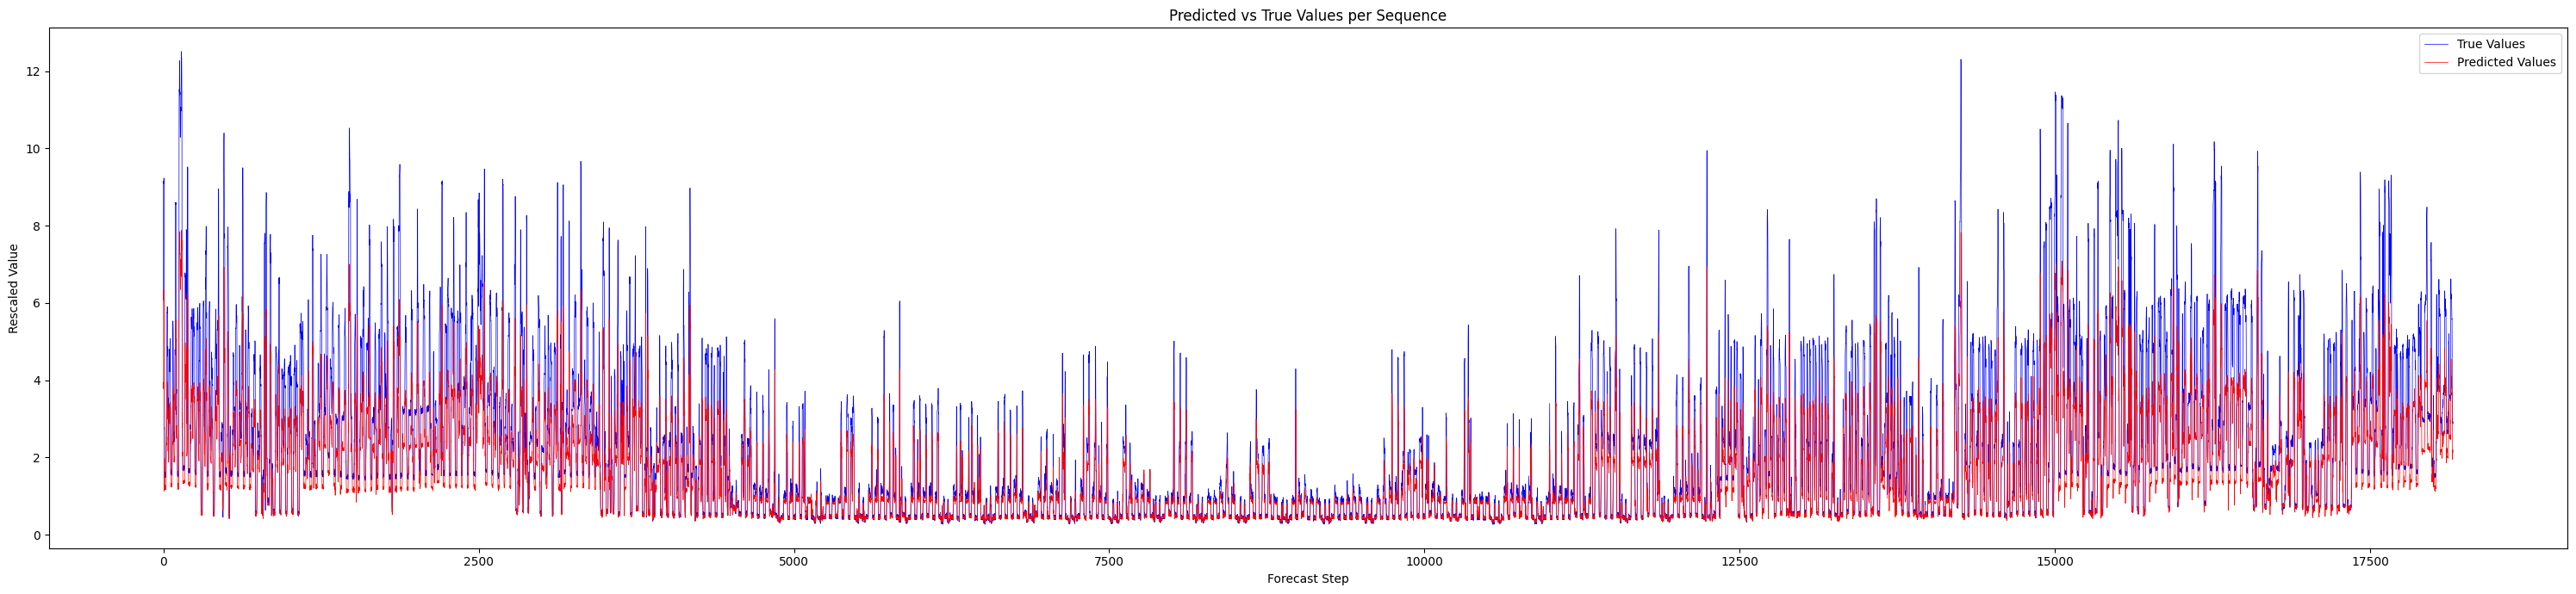


🔁 Training with lookback=2, horizon=2
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0536 - mae: 0.0536
Epoch 1: val_mae improved from inf to 0.02580, saving model to models/best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0535 - mae: 0.0535 - val_loss: 0.0258 - val_mae: 0.0258 - learning_rate: 0.0010
Epoch 2/150
272/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - mae: 0.0201
Epoch 2: val_mae improved from 0.02580 to 0.02373, saving model to models/best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 0.0010
Epoch 3/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - mae: 0.0183
Epoch 3: val_mae did not improve from 0.02373
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0238 - val_mae: 0.0238 - learning_rate: 0.0010
Epoch 4/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - mae: 0.0175
Epoch 4: val_mae improved from 0.02373 to 0.02201, saving model to models/best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0220 - val_mae: 0.0220 - learning_rate: 0.0010
Epoch 5/150
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - mae: 0.0173
Epoch 5: val_mae did not improve from 0.02201
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0230 - val_mae: 0.0230 - learning_rate: 0.0010
Epoch 6/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - mae: 0.0167
Epoch 6: val_mae improved from 0.02201 to 0.02197, saving model to models/best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0220 - val_mae: 0.0220 - learning_rate: 0.0010
Epoch 7/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 - mae: 0.0165
Epoch 7: val_mae did not improve from 0.02197
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0244 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 8/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - mae: 0.0154
Epoch 8: val_mae did not improve from 0.02197
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0282 - val_mae: 0.0282 - learning_rate: 0.0010
Epoch 9/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - mae: 0.0152
Epoch 9: val_mae did not improve from 0.02197
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0308 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 10/150
272/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - mae: 0.0149
Epoch 10:

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
📊 Evaluation Metrics:
MAE:  0.4264
RMSE: 0.8177
MAPE: 23.20%


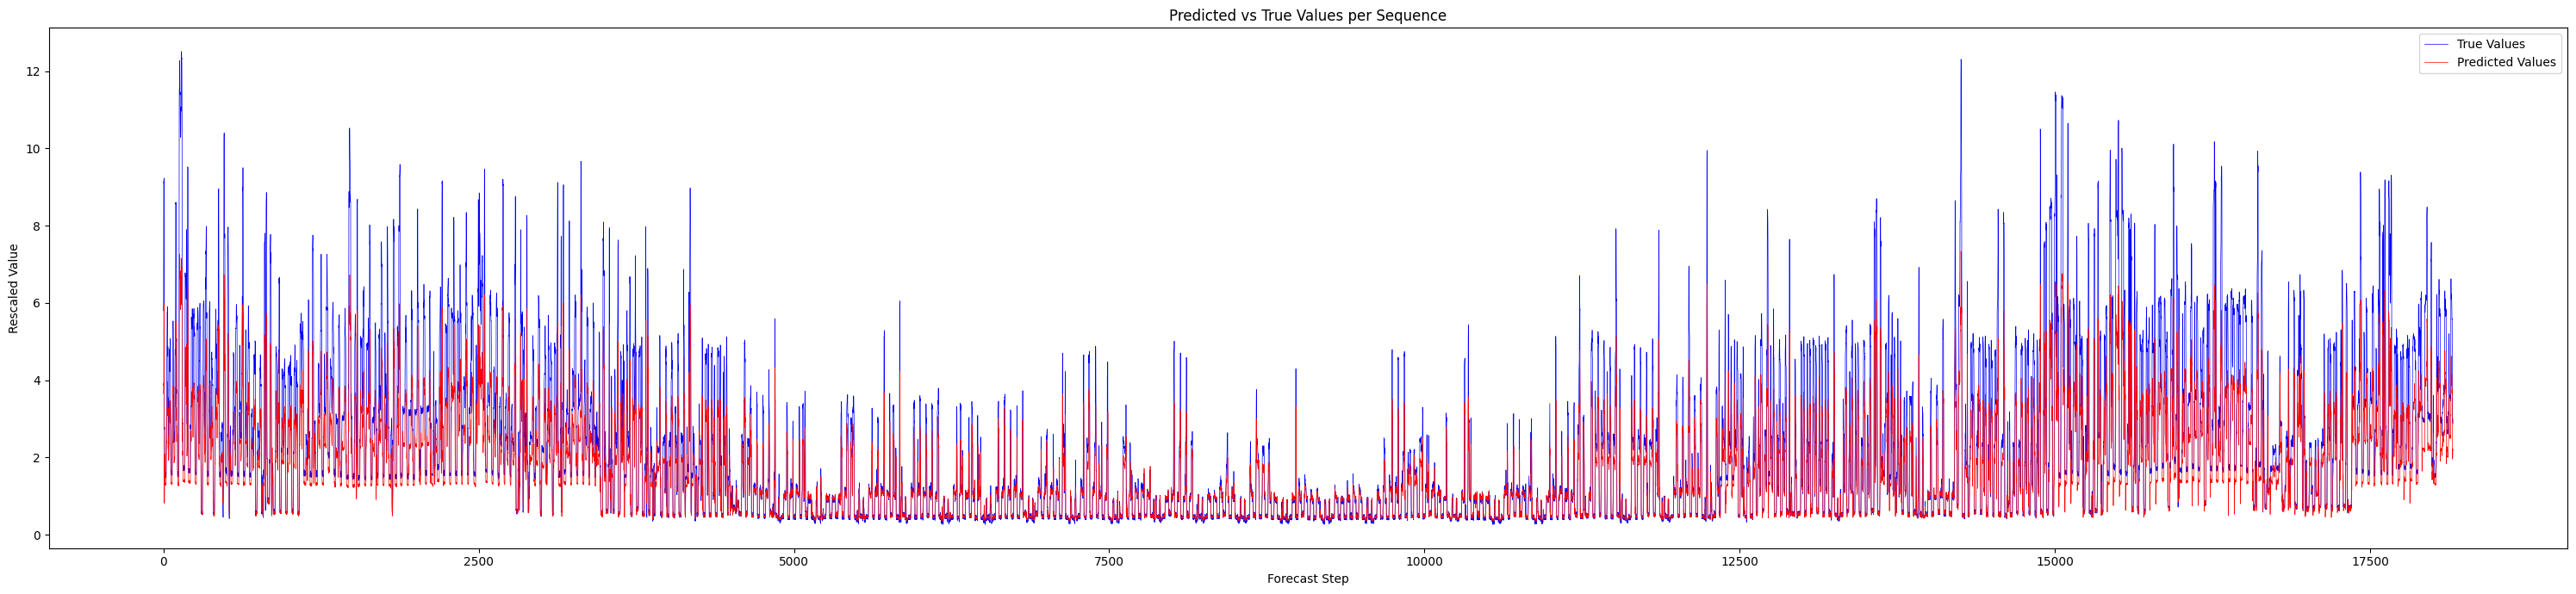


🔁 Training with lookback=2, horizon=6
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0588 - mae: 0.0588
Epoch 1: val_mae improved from inf to 0.03757, saving model to models/best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0585 - mae: 0.0585 - val_loss: 0.0376 - val_mae: 0.0376 - learning_rate: 0.0010
Epoch 2/150
271/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - mae: 0.0267
Epoch 2: val_mae improved from 0.03757 to 0.03658, saving model to models/best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0366 - val_mae: 0.0366 - learning_rate: 0.0010
Epoch 3/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - mae: 0.0251
Epoch 3: val_mae improved from 0.03658 to 0.03629, saving model to models/best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0363 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 4/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - mae: 0.0246
Epoch 4: val_mae did not improve from 0.03629
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0364 - val_mae: 0.0364 - learning_rate: 0.0010
Epoch 5/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - mae: 0.0240
Epoch 5: val_mae improved from 0.03629 to 0.03520, saving model to models/best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0352 - val_mae: 0.0352 - learning_rate: 0.0010
Epoch 6/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - mae: 0.0235
Epoch 6: val_mae improved from 0.03520 to 0.03467, saving model to models/best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0347 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 7/150
268/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - mae: 0.0231
Epoch 7: val_mae improved from 0.03467 to 0.03465, saving model to models/best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0346 - val_mae: 0.0346 - learning_rate: 0.0010
Epoch 8/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - mae: 0.0227
Epoch 8: val_mae did not improve from 0.03465
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0356 - val_mae: 0.0356 - learning_rate: 0.0010
Epoch 9/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - mae: 0.0218
Epoch 9: val_mae did not improve from 0.03465
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0356 - val_mae: 0.0356 - learning_rate: 0.0010
Epoch 10/150
268/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mae: 0.0216
Epoch 10: val_mae did not improve from 0.03465
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0371 - val_mae: 0.0371 - learning_rate: 0.0010
Epoch 11/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - mae: 0.0210
Epoch 1

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.6691
RMSE: 1.1827
MAPE: 37.42%


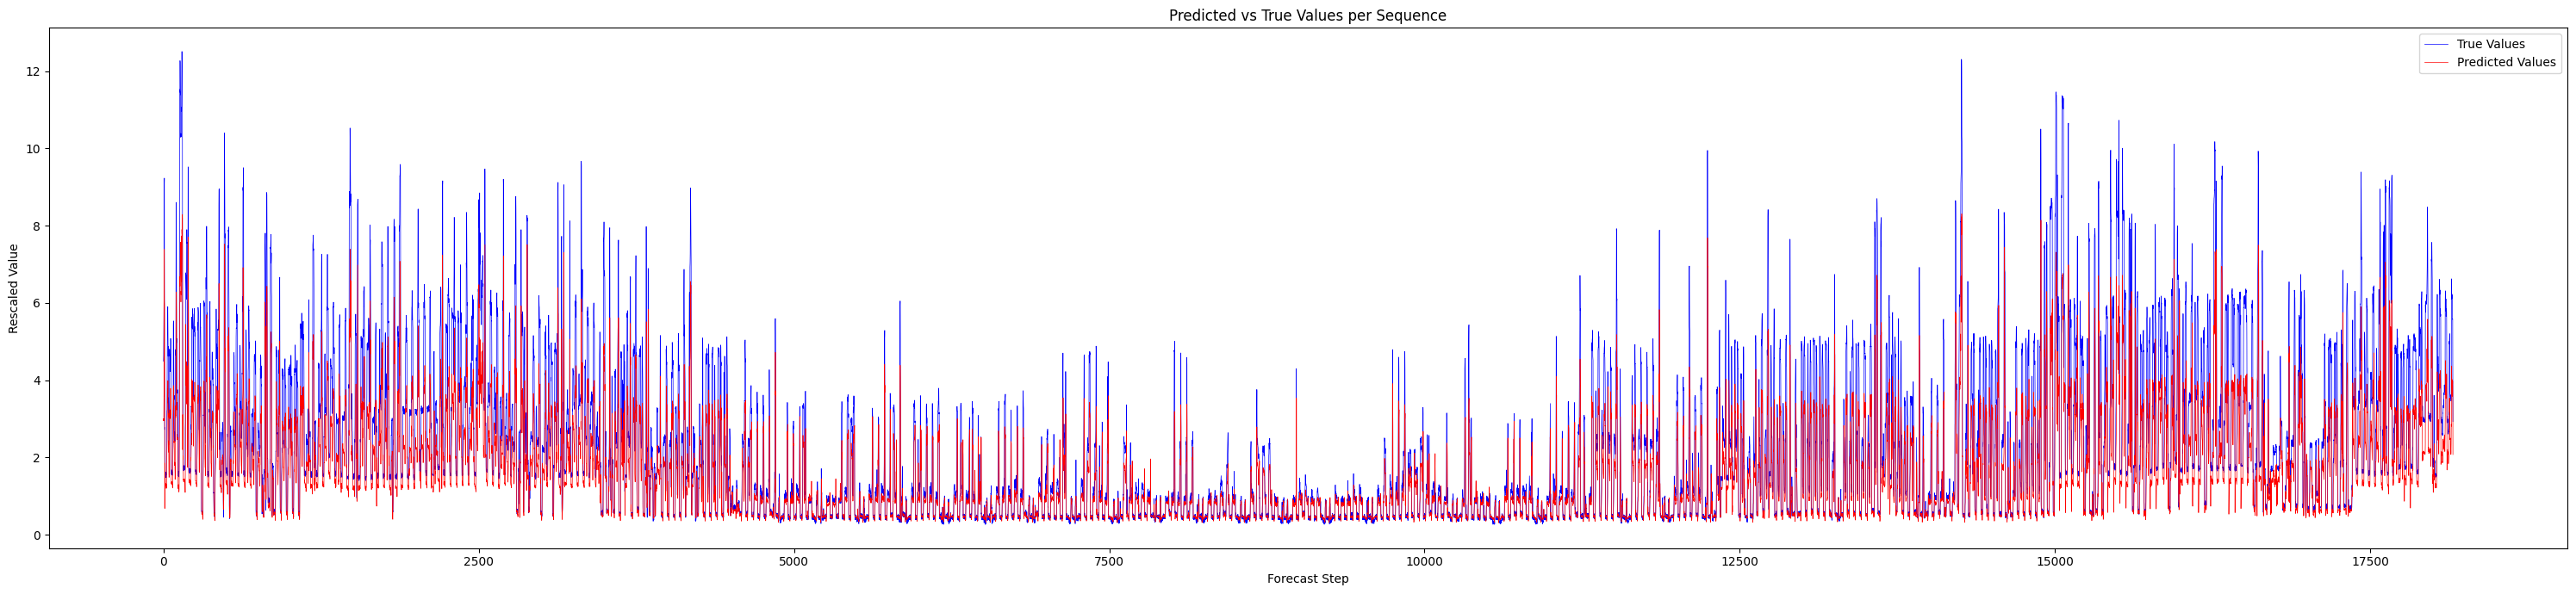


🔁 Training with lookback=6, horizon=1
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0520 - mae: 0.0520
Epoch 1: val_mae improved from inf to 0.03121, saving model to models/best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0520 - mae: 0.0520 - val_loss: 0.0312 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 2/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 - mae: 0.0212
Epoch 2: val_mae improved from 0.03121 to 0.02558, saving model to models/best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0256 - val_mae: 0.0256 - learning_rate: 0.0010
Epoch 3/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0186 - mae: 0.0186
Epoch 3: val_mae improved from 0.02558 to 0.02457, saving model to models/best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0246 - val_mae: 0.0246 - learning_rate: 0.0010
Epoch 4/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - mae: 0.0167
Epoch 4: val_mae improved from 0.02457 to 0.02325, saving model to models/best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0233 - val_mae: 0.0233 - learning_rate: 0.0010
Epoch 5/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - mae: 0.0155
Epoch 5: val_mae improved from 0.02325 to 0.02259, saving model to models/best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 6/150
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143 - mae: 0.0143
Epoch 6: val_mae did not improve from 0.02259
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0237 - val_mae: 0.0237 - learning_rate: 0.0010
Epoch 7/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - mae: 0.0141
Epoch 7: val_mae did not improve from 0.02259
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0238 - val_mae: 0.0238 - learning_rate: 0.0010
Epoch 8/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - mae: 0.0133
Epoch 8: val_mae improved from 0.02259 to 0.02250, saving model to models/best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0225 - val_mae: 0.0225 - learning_rate: 0.0010
Epoch 9/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - mae: 0.0132
Epoch 9: val_mae improved from 0.02250 to 0.02185, saving model to models/best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 10/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - mae: 0.0124
Epoch 10: val_mae did not improve from 0.02185
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0124 - mae: 0.0124 - val_loss: 0.0257 - val_mae: 0.0257 - learning_rate: 0.0010
Epoch 11/150
273/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - mae: 0.0124
Epoch 11: val_mae did not improve from 0.02185
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124 - mae: 0.0124 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 12/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - mae: 0.0119
Epoch 12: val_mae did not improve from 0.02185
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - mae: 0.0119 - val_loss: 0.0245 - val_mae: 0.0245 - learning_rate: 0.0010
Epoch 13/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - mae: 0.0117
Epo

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.4149
RMSE: 0.7405
MAPE: 19.76%


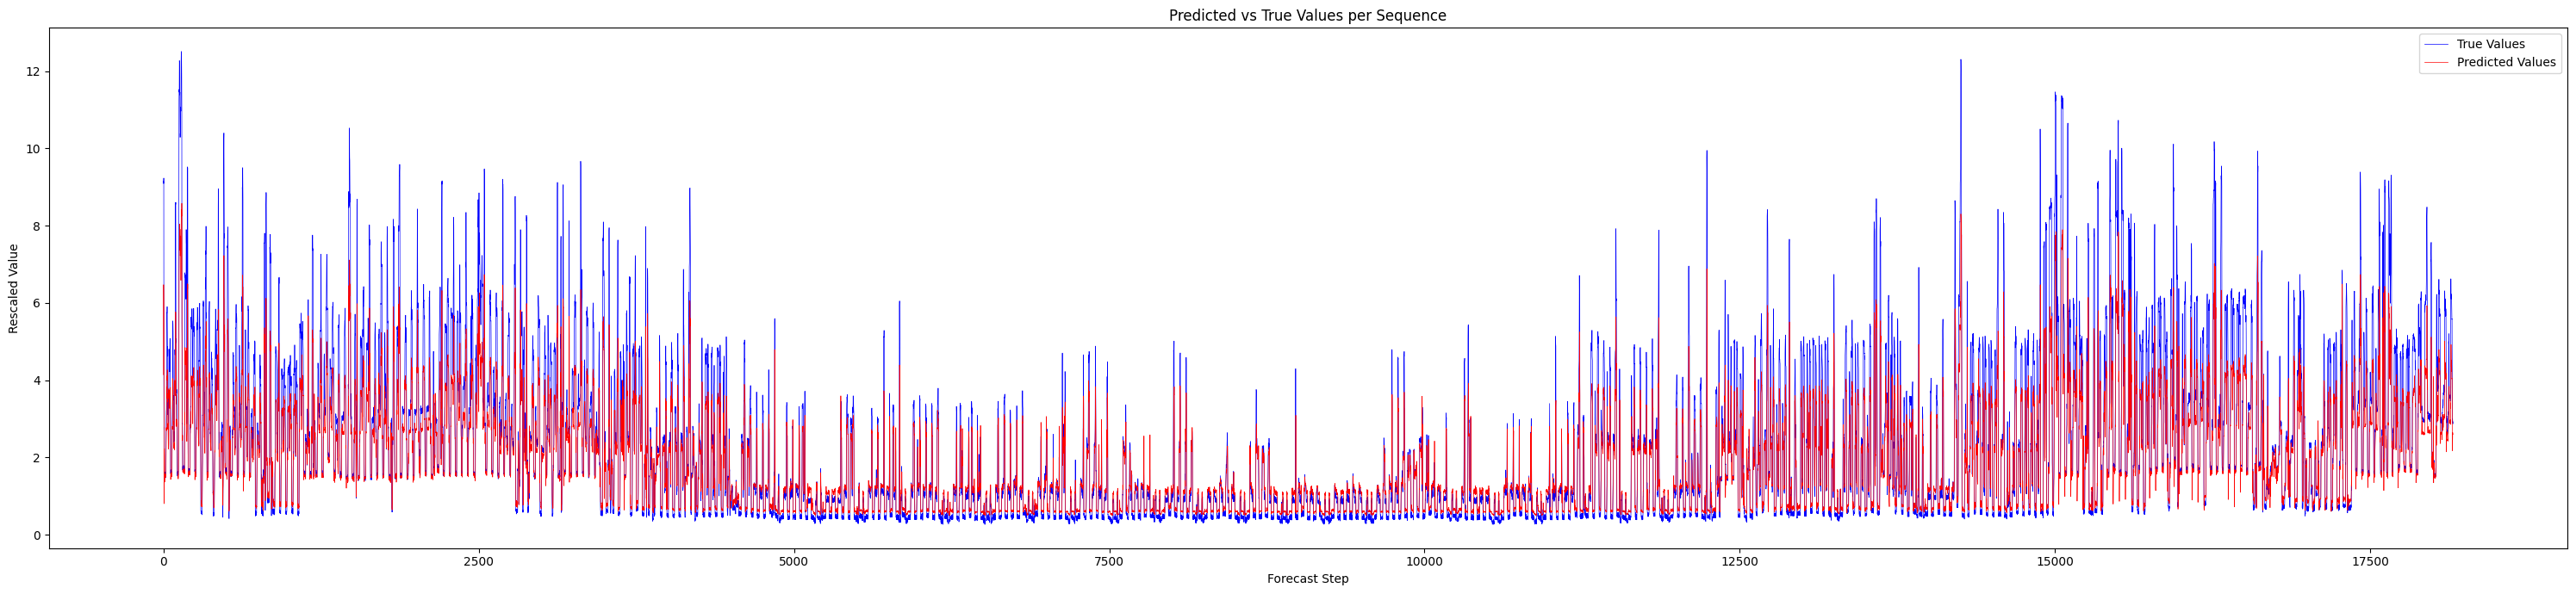


🔁 Training with lookback=6, horizon=2
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0508 - mae: 0.0508
Epoch 1: val_mae improved from inf to 0.03125, saving model to models/best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0505 - mae: 0.0505 - val_loss: 0.0313 - val_mae: 0.0313 - learning_rate: 0.0010
Epoch 2/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0229 - mae: 0.0229
Epoch 2: val_mae improved from 0.03125 to 0.03103, saving model to models/best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0310 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 3/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0211 - mae: 0.0211
Epoch 3: val_mae improved from 0.03103 to 0.02877, saving model to models/best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0288 - val_mae: 0.0288 - learning_rate: 0.0010
Epoch 4/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193 - mae: 0.0193
Epoch 4: val_mae improved from 0.02877 to 0.02741, saving model to models/best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.0274 - val_mae: 0.0274 - learning_rate: 0.0010
Epoch 5/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - mae: 0.0178
Epoch 5: val_mae improved from 0.02741 to 0.02656, saving model to models/best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0266 - val_mae: 0.0266 - learning_rate: 0.0010
Epoch 6/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - mae: 0.0173
Epoch 6: val_mae did not improve from 0.02656
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0312 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 7/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - mae: 0.0170
Epoch 7: val_mae did not improve from 0.02656
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0266 - val_mae: 0.0266 - learning_rate: 0.0010
Epoch 8/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 - mae: 0.0156
Epoch 8: val_mae improved from 0.02656 to 0.02465, saving model to models/best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0247 - val_mae: 0.0247 - learning_rate: 0.0010
Epoch 9/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - mae: 0.0157
Epoch 9: val_mae did not improve from 0.02465
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0253 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 10/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - mae: 0.0155
Epoch 10: val_mae did not improve from 0.02465
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0254 - val_mae: 0.0254 - learning_rate: 0.0010
Epoch 11/150
273/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - mae: 0.0148
Epoch 11: val_mae did not improve from 0.02465
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0269 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 12/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - mae: 0.0147
Epoch

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.4844
RMSE: 0.8614
MAPE: 25.35%


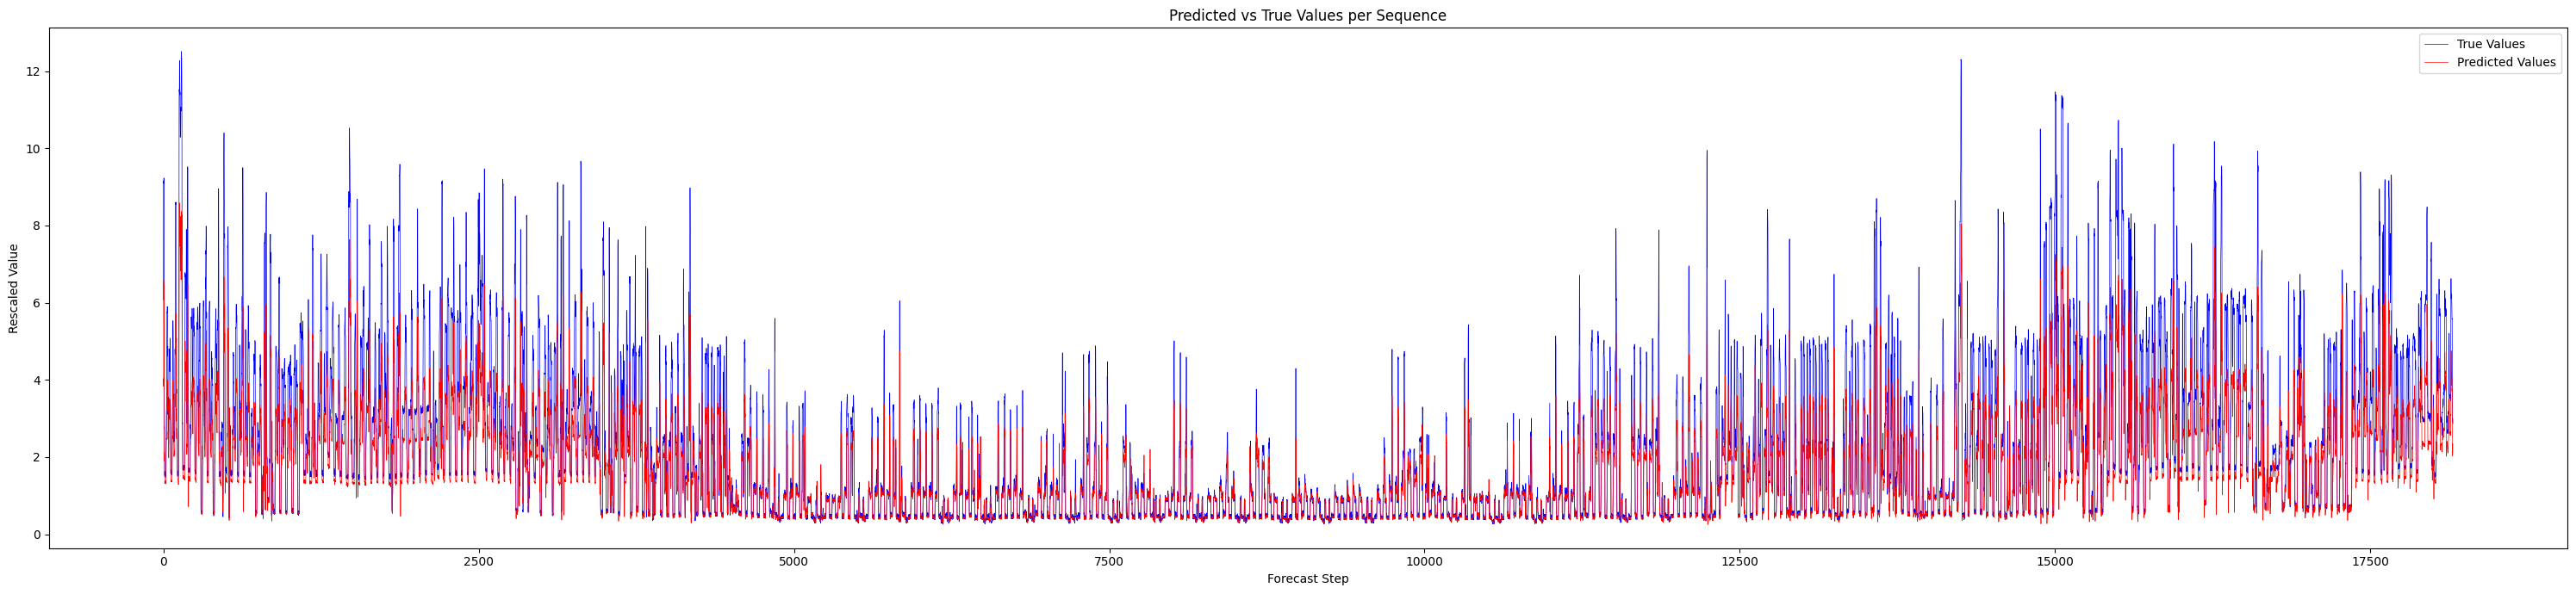


🔁 Training with lookback=6, horizon=6
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0535 - mae: 0.0535
Epoch 1: val_mae improved from inf to 0.04074, saving model to models/best_model_6_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0532 - mae: 0.0532 - val_loss: 0.0407 - val_mae: 0.0407 - learning_rate: 0.0010
Epoch 2/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - mae: 0.0280
Epoch 2: val_mae improved from 0.04074 to 0.03901, saving model to models/best_model_6_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0390 - val_mae: 0.0390 - learning_rate: 0.0010
Epoch 3/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0262 - mae: 0.0262
Epoch 3: val_mae improved from 0.03901 to 0.03887, saving model to models/best_model_6_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0389 - val_mae: 0.0389 - learning_rate: 0.0010
Epoch 4/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0251 - mae: 0.0251
Epoch 4: val_mae improved from 0.03887 to 0.03732, saving model to models/best_model_6_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0373 - val_mae: 0.0373 - learning_rate: 0.0010
Epoch 5/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - mae: 0.0243
Epoch 5: val_mae did not improve from 0.03732
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0378 - val_mae: 0.0378 - learning_rate: 0.0010
Epoch 6/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - mae: 0.0242
Epoch 6: val_mae improved from 0.03732 to 0.03710, saving model to models/best_model_6_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0371 - val_mae: 0.0371 - learning_rate: 0.0010
Epoch 7/150
273/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - mae: 0.0235
Epoch 7: val_mae did not improve from 0.03710
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0374 - val_mae: 0.0374 - learning_rate: 0.0010
Epoch 8/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - mae: 0.0229
Epoch 8: val_mae did not improve from 0.03710
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0405 - val_mae: 0.0405 - learning_rate: 0.0010
Epoch 9/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - mae: 0.0231
Epoch 9: val_mae did not improve from 0.03710
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0416 - val_mae: 0.0416 - learning_rate: 0.0010
Epoch 10/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - mae: 0.0228
Epoch 10:

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.7246
RMSE: 1.2661
MAPE: 38.02%


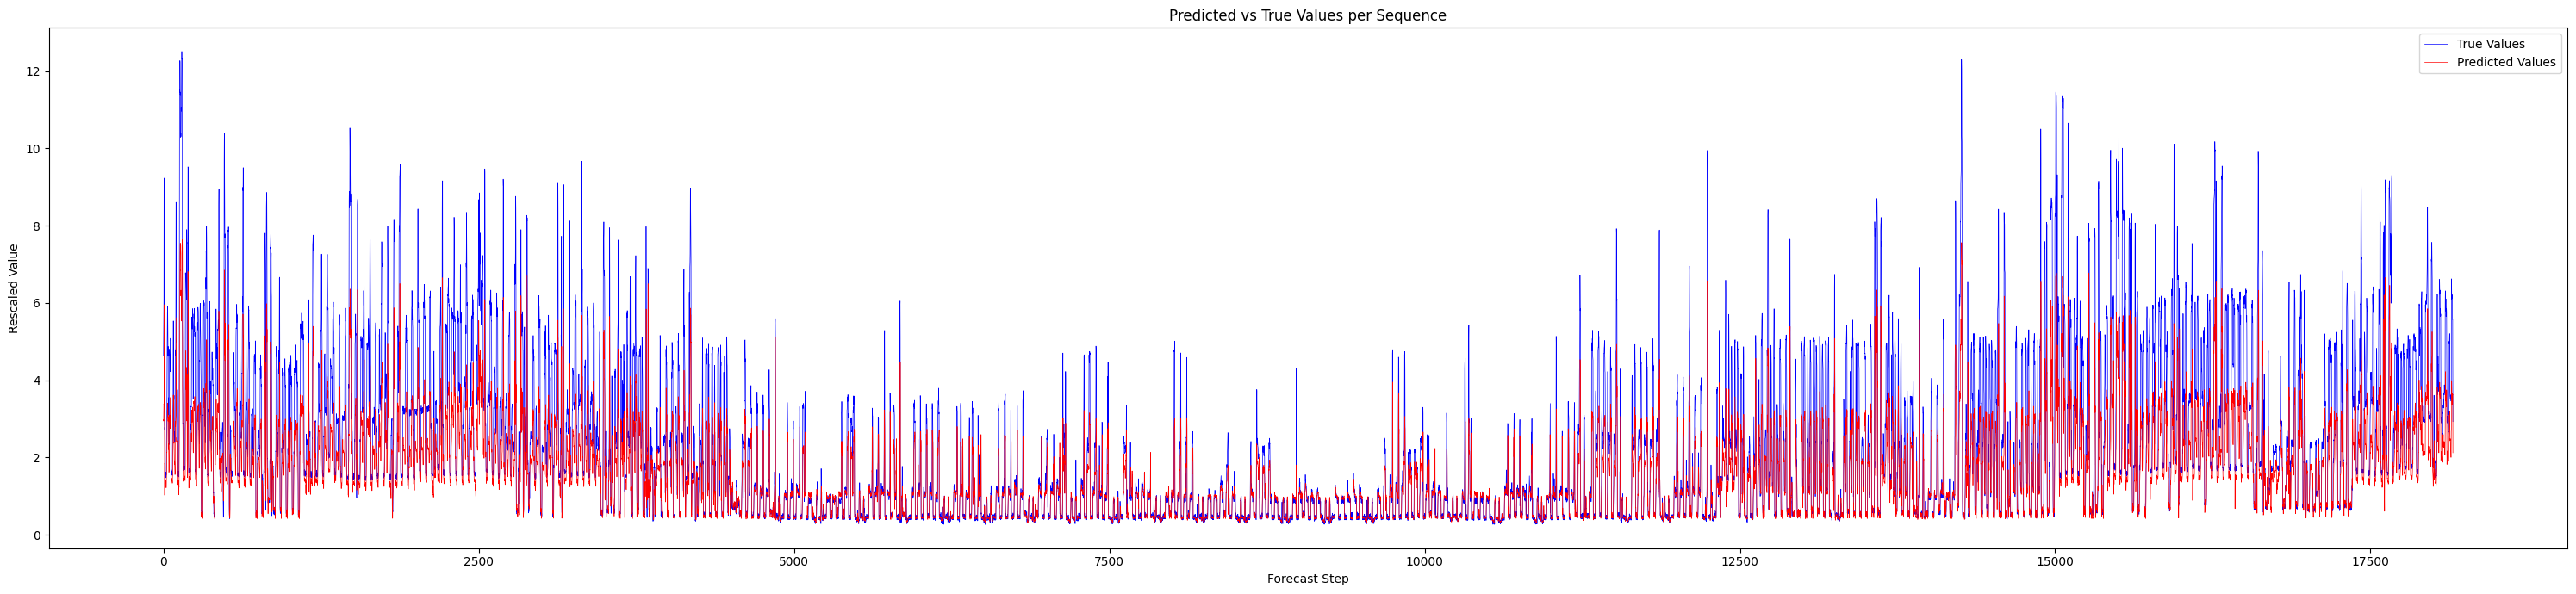


🔁 Training with lookback=12, horizon=1
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0555 - mae: 0.0555
Epoch 1: val_mae improved from inf to 0.03915, saving model to models/best_model_12_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0391 - val_mae: 0.0391 - learning_rate: 0.0010
Epoch 2/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0242 - mae: 0.0242
Epoch 2: val_mae improved from 0.03915 to 0.03020, saving model to models/best_model_12_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0302 - val_mae: 0.0302 - learning_rate: 0.0010
Epoch 3/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - mae: 0.0205
Epoch 3: val_mae improved from 0.03020 to 0.02706, saving model to models/best_model_12_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0271 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 4/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - mae: 0.0174
Epoch 4: val_mae improved from 0.02706 to 0.02184, saving model to models/best_model_12_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0218 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 5/150
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - mae: 0.0158
Epoch 5: val_mae did not improve from 0.02184
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0158 - mae: 0.0158 - val_loss: 0.0264 - val_mae: 0.0264 - learning_rate: 0.0010
Epoch 6/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mae: 0.0153
Epoch 6: val_mae did not improve from 0.02184
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0253 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 7/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - mae: 0.0142
Epoch 7: val_mae did not improve from 0.02184
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 8/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - mae: 0.0137
Epoch 8: v

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.4323
RMSE: 0.7713
MAPE: 23.78%


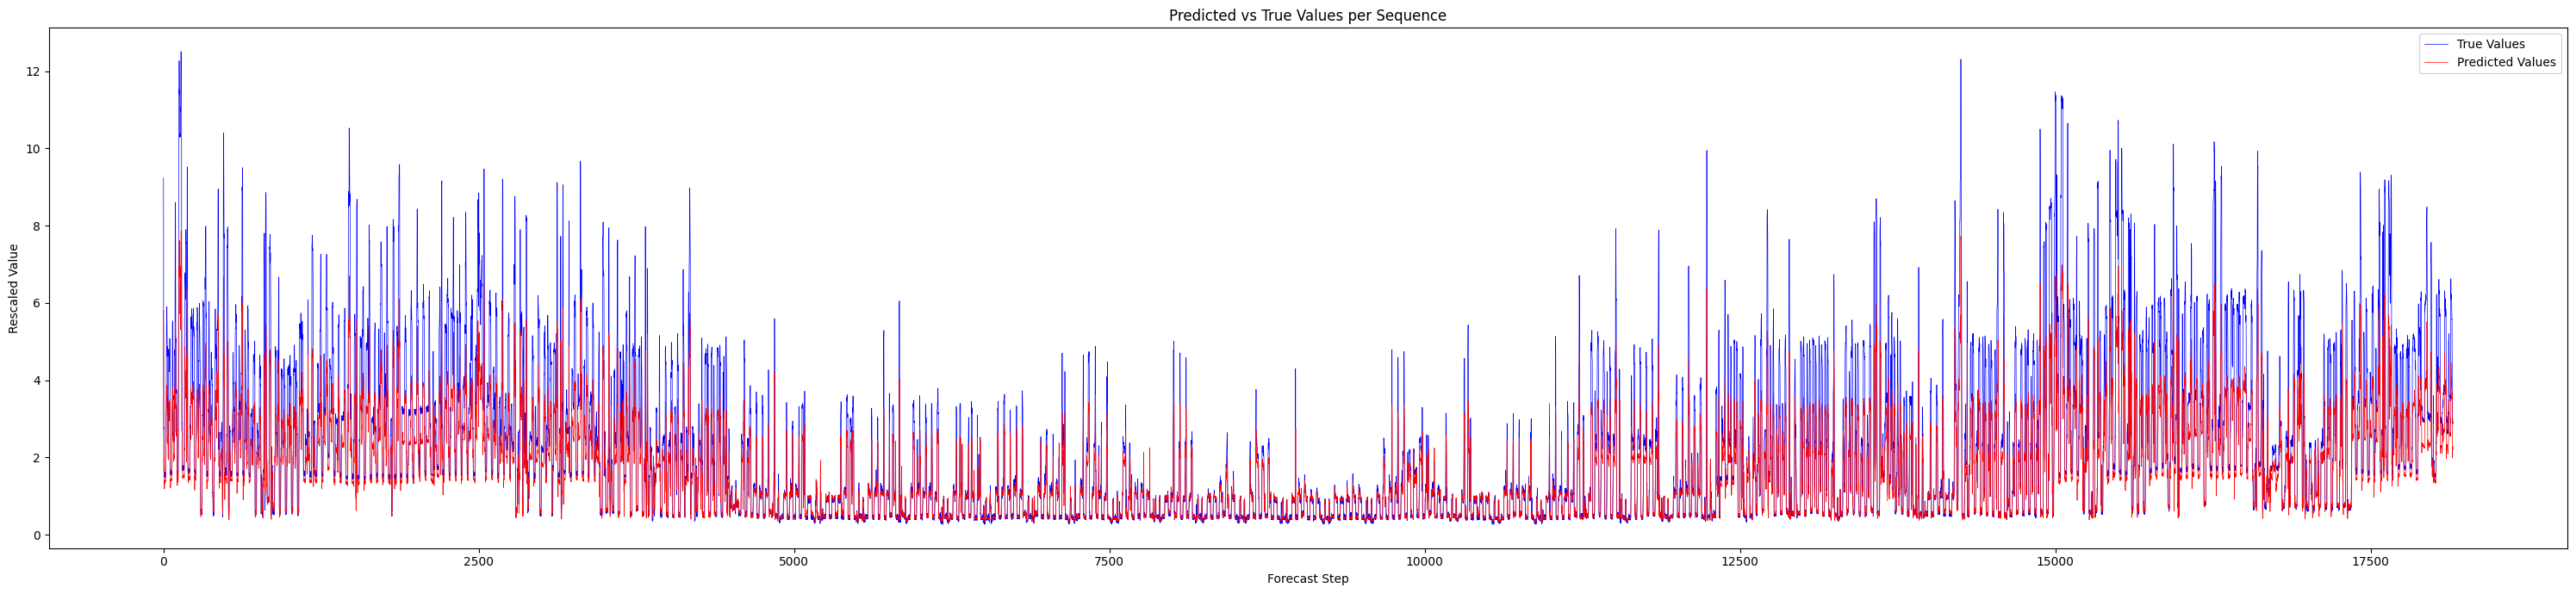


🔁 Training with lookback=12, horizon=2
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0549 - mae: 0.0549
Epoch 1: val_mae improved from inf to 0.03848, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0545 - mae: 0.0545 - val_loss: 0.0385 - val_mae: 0.0385 - learning_rate: 0.0010
Epoch 2/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - mae: 0.0258
Epoch 2: val_mae improved from 0.03848 to 0.03237, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0324 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 3/150
272/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - mae: 0.0223
Epoch 3: val_mae improved from 0.03237 to 0.02781, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0278 - val_mae: 0.0278 - learning_rate: 0.0010
Epoch 4/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - mae: 0.0200
Epoch 4: val_mae improved from 0.02781 to 0.02532, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0253 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 5/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - mae: 0.0187
Epoch 5: val_mae improved from 0.02532 to 0.02461, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0246 - val_mae: 0.0246 - learning_rate: 0.0010
Epoch 6/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - mae: 0.0177
Epoch 6: val_mae improved from 0.02461 to 0.02399, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0240 - val_mae: 0.0240 - learning_rate: 0.0010
Epoch 7/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - mae: 0.0170
Epoch 7: val_mae improved from 0.02399 to 0.02317, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0232 - val_mae: 0.0232 - learning_rate: 0.0010
Epoch 8/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - mae: 0.0166
Epoch 8: val_mae improved from 0.02317 to 0.02293, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0229 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 9/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162 - mae: 0.0162
Epoch 9: val_mae improved from 0.02293 to 0.02242, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 10/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158 - mae: 0.0158
Epoch 10: val_mae improved from 0.02242 to 0.02224, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - mae: 0.0158 - val_loss: 0.0222 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 11/150
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - mae: 0.0158
Epoch 11: val_mae did not improve from 0.02224
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - mae: 0.0158 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 12/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - mae: 0.0154
Epoch 12: val_mae did not improve from 0.02224
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 13/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - mae: 0.0150
Epoch 13: val_mae improved from 0.02224 to 0.02143, saving model to models/best_model_12_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0214 - val_mae: 0.0214 - learning_rate: 0.0010
Epoch 14/150
273/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - mae: 0.0148
Epoch 14: val_mae did not improve from 0.02143
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 15/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - mae: 0.0148
Epoch 15: val_mae did not improve from 0.02143
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 16/150
274/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - mae: 0.0145
Epoch 16: val_mae did not improve from 0.02143
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0234 - val_mae: 0.0234 - learning_rate: 0.0010
Epoch 17/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - mae: 0.0147
Epo

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'learning_rate'])
✅ Loaded saved model from: models/best_model_12_2.h5
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.4074
RMSE: 0.7800
MAPE: 22.12%


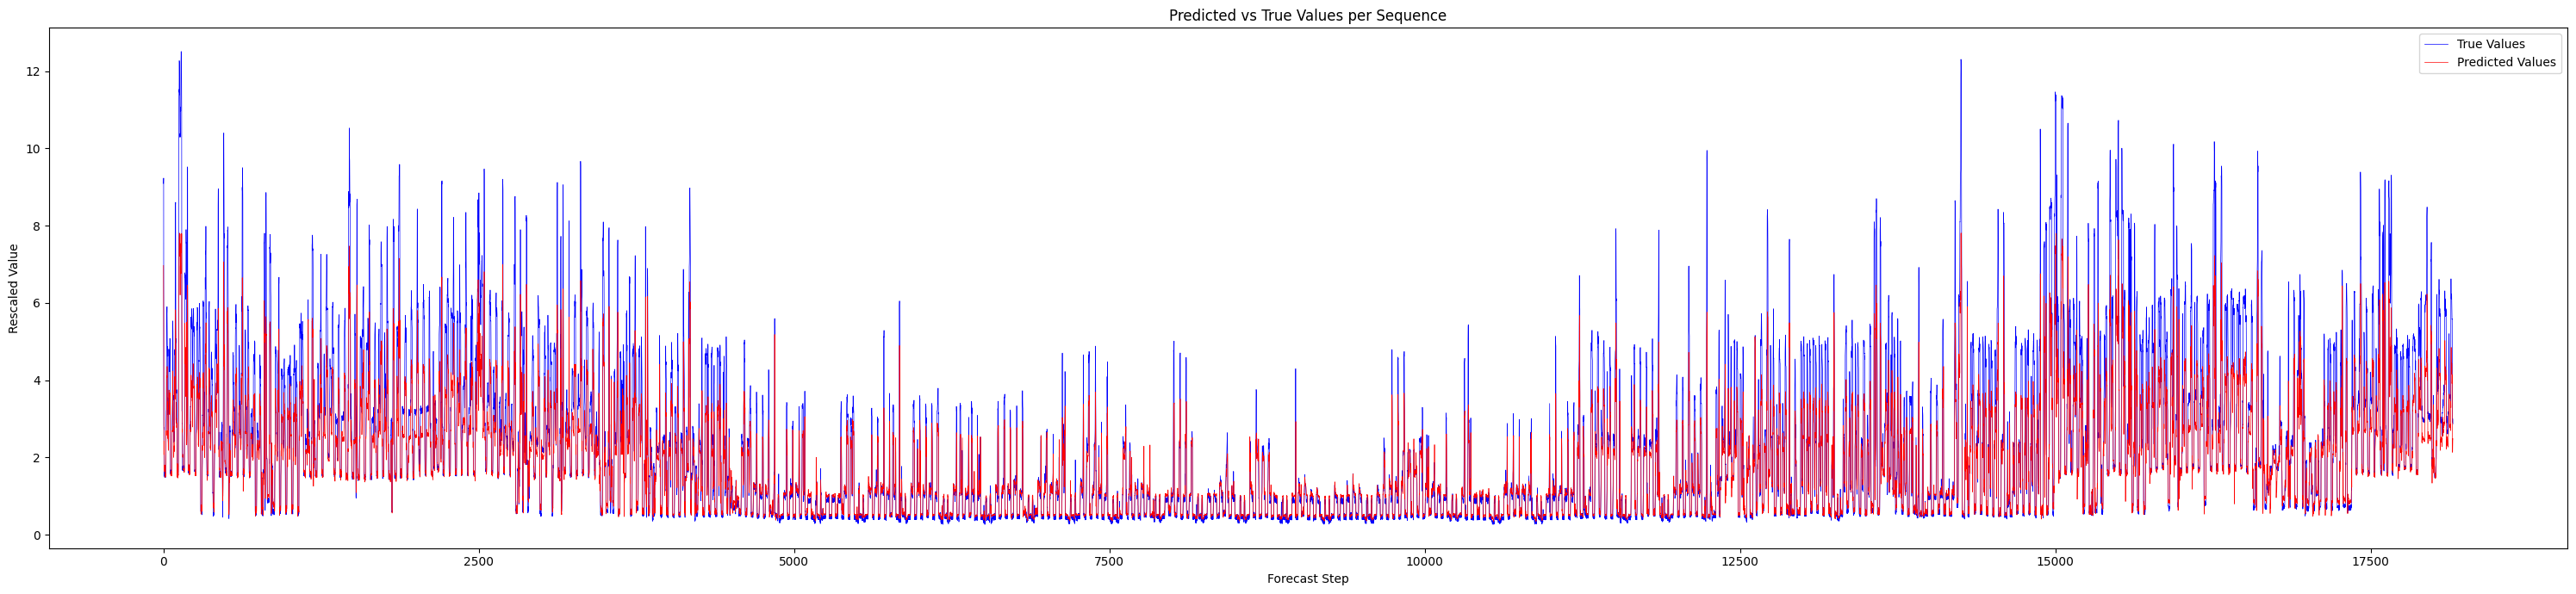


🔁 Training with lookback=12, horizon=6
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0568 - mae: 0.0568
Epoch 1: val_mae improved from inf to 0.04486, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0563 - mae: 0.0563 - val_loss: 0.0449 - val_mae: 0.0449 - learning_rate: 0.0010
Epoch 2/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 - mae: 0.0286
Epoch 2: val_mae improved from 0.04486 to 0.04197, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0420 - val_mae: 0.0420 - learning_rate: 0.0010
Epoch 3/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - mae: 0.0267
Epoch 3: val_mae improved from 0.04197 to 0.04125, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0413 - val_mae: 0.0413 - learning_rate: 0.0010
Epoch 4/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0254 - mae: 0.0254
Epoch 4: val_mae did not improve from 0.04125
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0416 - val_mae: 0.0416 - learning_rate: 0.0010
Epoch 5/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - mae: 0.0248
Epoch 5: val_mae improved from 0.04125 to 0.03720, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0372 - val_mae: 0.0372 - learning_rate: 0.0010
Epoch 6/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - mae: 0.0240
Epoch 6: val_mae improved from 0.03720 to 0.03677, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0368 - val_mae: 0.0368 - learning_rate: 0.0010
Epoch 7/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - mae: 0.0235
Epoch 7: val_mae improved from 0.03677 to 0.03475, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0347 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 8/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - mae: 0.0228
Epoch 8: val_mae did not improve from 0.03475
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0358 - val_mae: 0.0358 - learning_rate: 0.0010
Epoch 9/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - mae: 0.0227
Epoch 9: val_mae did not improve from 0.03475
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0350 - val_mae: 0.0350 - learning_rate: 0.0010
Epoch 10/150
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - mae: 0.0221
Epoch 10: val_mae improved from 0.03475 to 0.03412, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0341 - val_mae: 0.0341 - learning_rate: 0.0010
Epoch 11/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mae: 0.0215
Epoch 11: val_mae improved from 0.03412 to 0.03406, saving model to models/best_model_12_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0341 - val_mae: 0.0341 - learning_rate: 0.0010
Epoch 12/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mae: 0.0217
Epoch 12: val_mae did not improve from 0.03406
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0353 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 13/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0212 - mae: 0.0212
Epoch 13: val_mae did not improve from 0.03406
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0355 - val_mae: 0.0355 - learning_rate: 0.0010
Epoch 14/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - mae: 0.0208
Epoch 14: val_mae did not improve from 0.03406
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0353 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 15/150
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 - mae: 0.0207
Epo


✅ Loaded saved model from: models/best_model_12_6.h5
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.6608
RMSE: 1.1638
MAPE: 34.74%


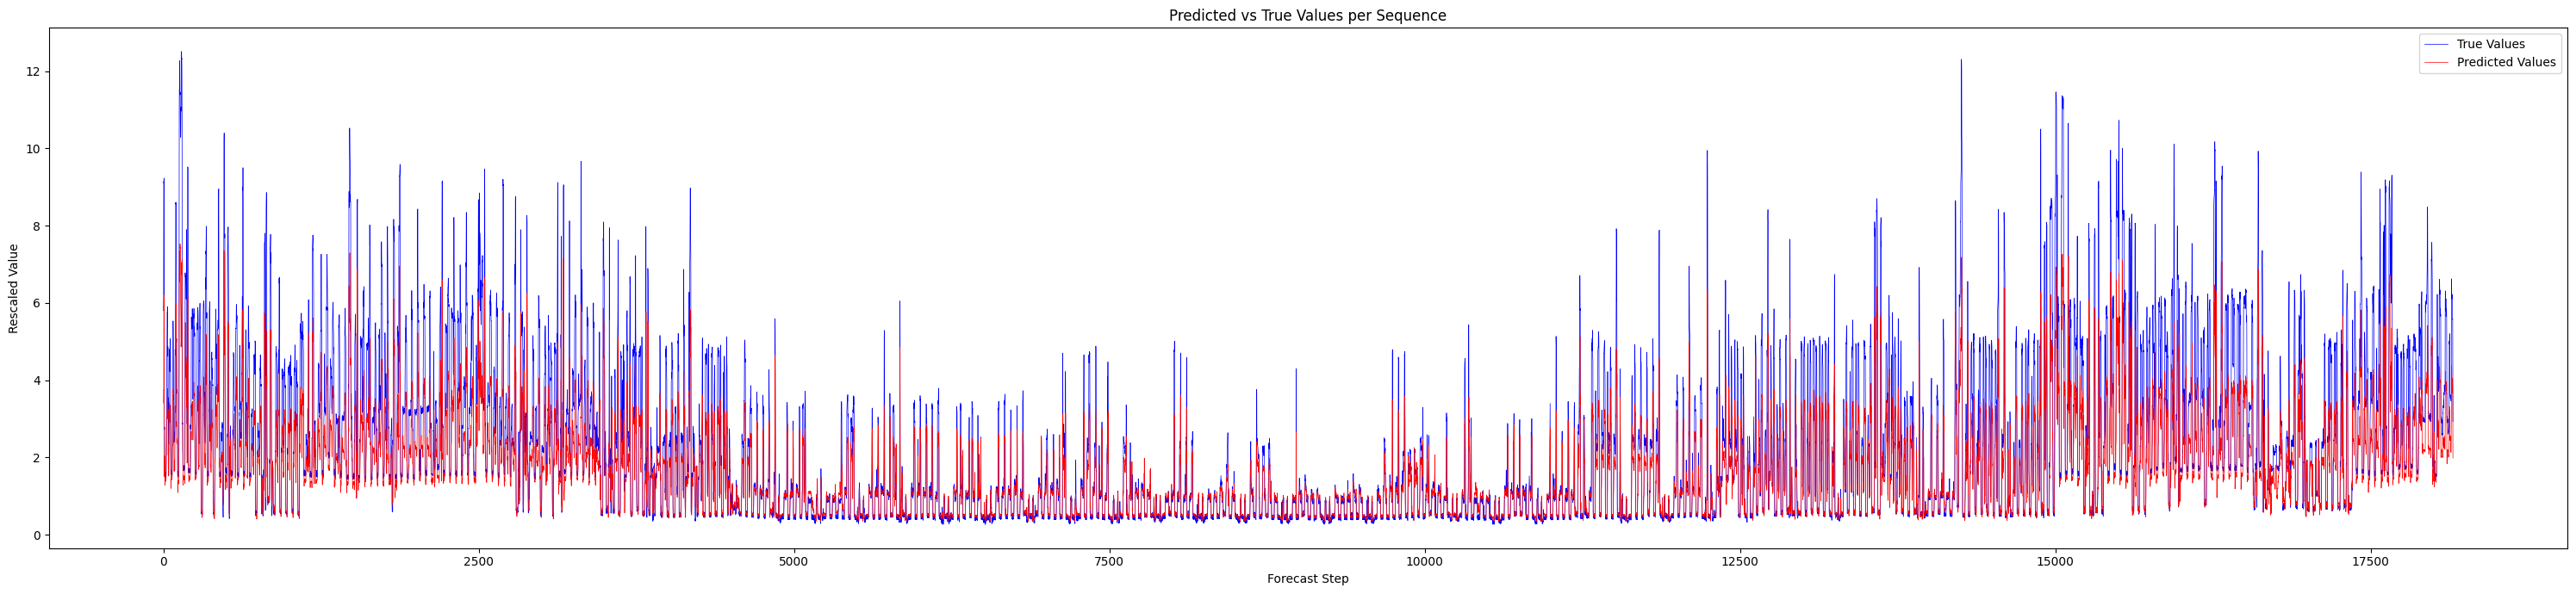


✅ Final Results:
   lookback  lookahead       mae      rmse       mape
0         2          1  0.407226  0.750408  20.802039
1         2          2  0.426393  0.817662  23.203790
2         2          6  0.669143  1.182671  37.424534
3         6          1  0.414881  0.740497  19.756555
4         6          2  0.484427  0.861366  25.345768
5         6          6  0.724586  1.266059  38.020668
6        12          1  0.432253  0.771303  23.778070
7        12          2  0.407395  0.779965  22.117247
8        12          6  0.660801  1.163831  34.742624


In [8]:
import pandas as pd
from tensorflow.keras.models import load_model
import os 

results = []

timesteps_list = [2, 6, 12]
horizon_list = [1, 2, 6]

for input_window in timesteps_list:
    for forecast_horizon in horizon_list:
        print(f"\n🔁 Training with lookback={input_window}, horizon={forecast_horizon}")
        try:
            # Prepare sequences
            X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_sequences(
                df, input_window=input_window, forecast_horizon=forecast_horizon,
                val_ratio=0.1, test_ratio=0.3
            )
            # Build model
            model = build_cnn_lstm_model(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                output_size=y_train.shape[1]
            )

            model_path = f"models/best_model_{input_window}_{forecast_horizon}.h5"

            # Train and save the best model
            model, history = train_model(model, X_train, y_train, X_val, y_val, model_path=model_path)

            # Try to load the best saved model; fallback to last epoch model if not saved
            if os.path.exists(model_path):
                print(f"✅ Loaded saved model from: {model_path}")
                best_model = load_model(model_path)
            else:
                print(f"⚠️ No saved model found for {input_window}-{forecast_horizon}. Using model from last epoch.")
                best_model = model

            # Evaluate loaded model
            metrics = evaluate_forecasting_model(best_model, X_test, y_test, scaler)

            # Save results
            results.append({
                "lookback": input_window,
                "lookahead": forecast_horizon,
                "mae": metrics["mae"],
                "rmse": metrics["rmse"],
                "mape": metrics["mape"]
            })

            plot(model, X_test, y_test, scaler)
        
        except Exception as e:
            print(f"❌ Failed for lookback={input_window}, horizon={forecast_horizon}: {e}")
            results.append({
                "lookback": input_window,
                "lookahead": forecast_horizon,
                "mae": None,
                "rmse": None,
                "mape": None
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n✅ Final Results:")
print(results_df)


In [9]:
results_df.to_csv("results.csv", index=False)

In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


def parse_model_name(name):
    parts = name.split("_")
    return int(parts[-2]), int(parts[-1])  # input_window, forecast_horizon


def horizon_rolling_forecast(model, initial_input, X_test, forecast_horizon, input_window, scaler):
    preds = []
    current_input = initial_input.copy()
    total_chunks = len(X_test) // forecast_horizon

    for i in range(total_chunks):
        print(f"🔮 Forecast chunk {i + 1}/{total_chunks}", end='\r', flush=True)

        # Predict next horizon values
        pred = model.predict(current_input, verbose=0)[0]  # shape: (horizon,)
        preds.extend(pred.tolist())

        # Get real input features for next horizon
        x_next_chunk = X_test[i * forecast_horizon: (i + 1) * forecast_horizon]

        # If 3D, take last timestep per horizon step
        if x_next_chunk.ndim == 3:
            x_next_chunk = x_next_chunk[:, -1, :]  # shape: (horizon, features)

        # Exclude target column (assumed to be first column)
        x_next_features = x_next_chunk[:, 1:]  # shape: (horizon, feature_dim - 1)

        # Combine predicted target + real features
        pred_array = np.array(pred).reshape(forecast_horizon, 1)  # shape: (horizon, 1)
        combined = np.concatenate([pred_array, x_next_features], axis=1)  # shape: (horizon, feature_dim)

        # Update current input window
        current_input = np.concatenate([
            current_input.reshape(-1, current_input.shape[-1]),  # shape: (input_window, feature_dim)
            combined
        ], axis=0)

        # Trim to keep only last `input_window` steps and reshape to model input shape
        current_input = current_input[-input_window:].reshape(1, input_window, -1)

    preds = np.array(preds).reshape(-1, 1)
    return scaler.inverse_transform(preds).flatten()


def plot_iterative(true_vals, pred_vals, label="Model"):
    plt.figure(figsize=(30, 7))
    plt.plot(true_vals, label="True Values", color="blue", linewidth=0.5)
    plt.plot(pred_vals, label=f"Predicted by {label}", color="red", linewidth=0.5)
    plt.title(f"Iterative Forecast: {label}")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()



✅ Loaded model: best_model_12_1 with window=12, horizon=1
🔁 Running iterative forecast for best_model_12_1 with input_window=12, forecast_horizon=1


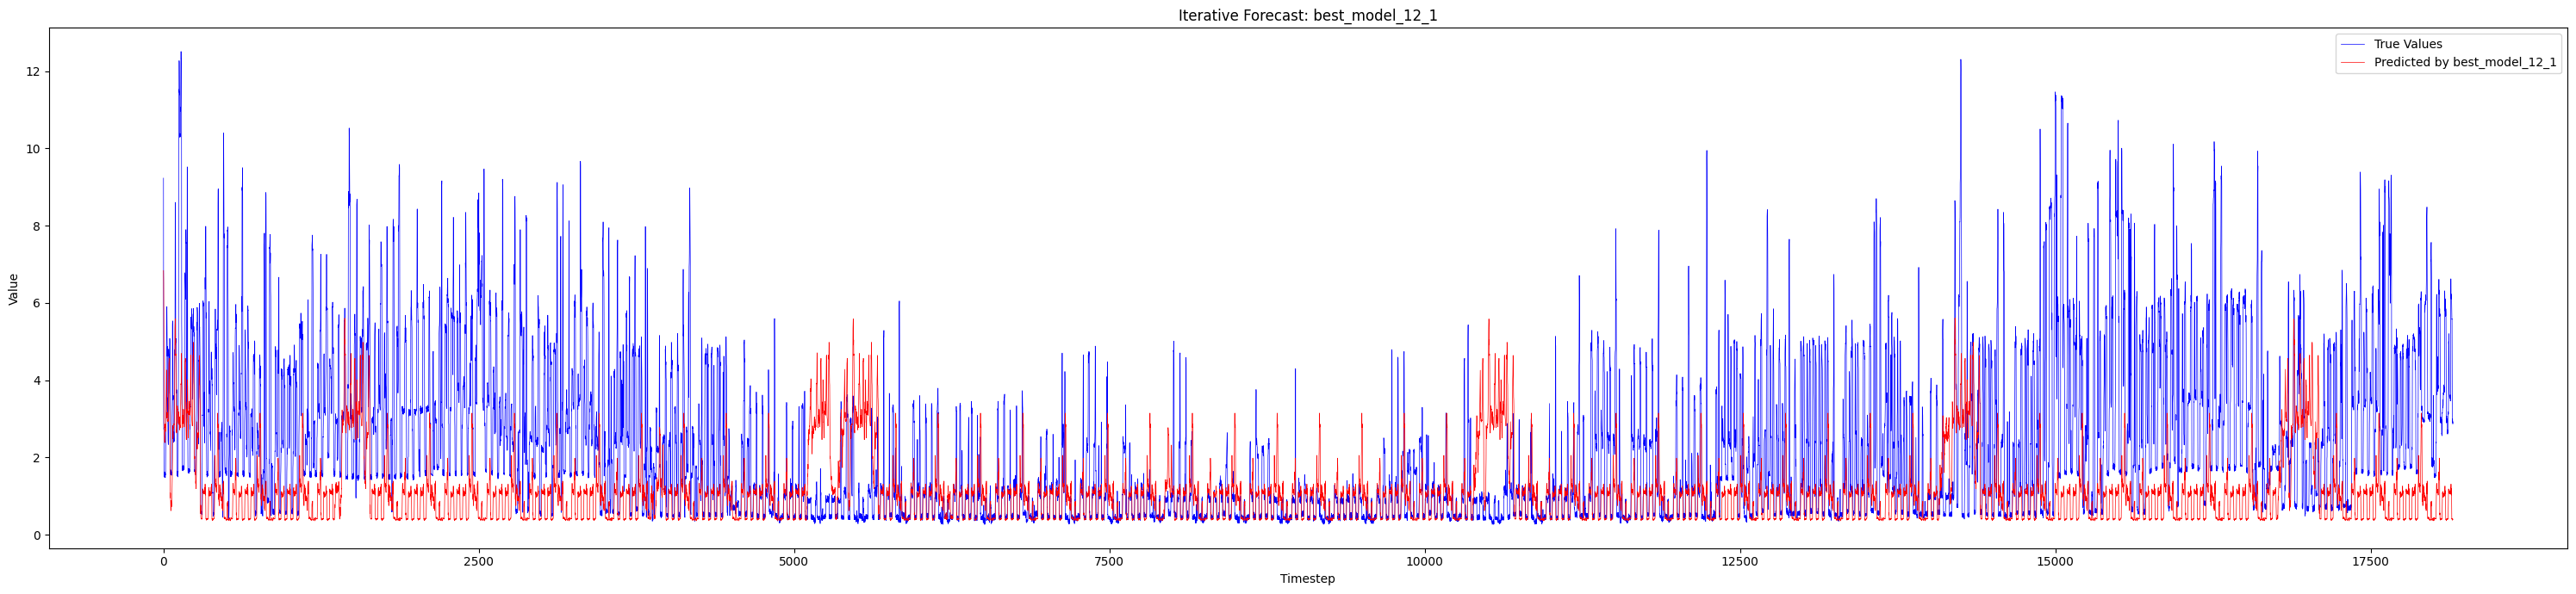

📊 Evaluation Metrics:
MAE:  1.5109
RMSE: 2.2977
MAPE: 72.56%
✅ Loaded model: best_model_12_2 with window=12, horizon=2
🔁 Running iterative forecast for best_model_12_2 with input_window=12, forecast_horizon=2


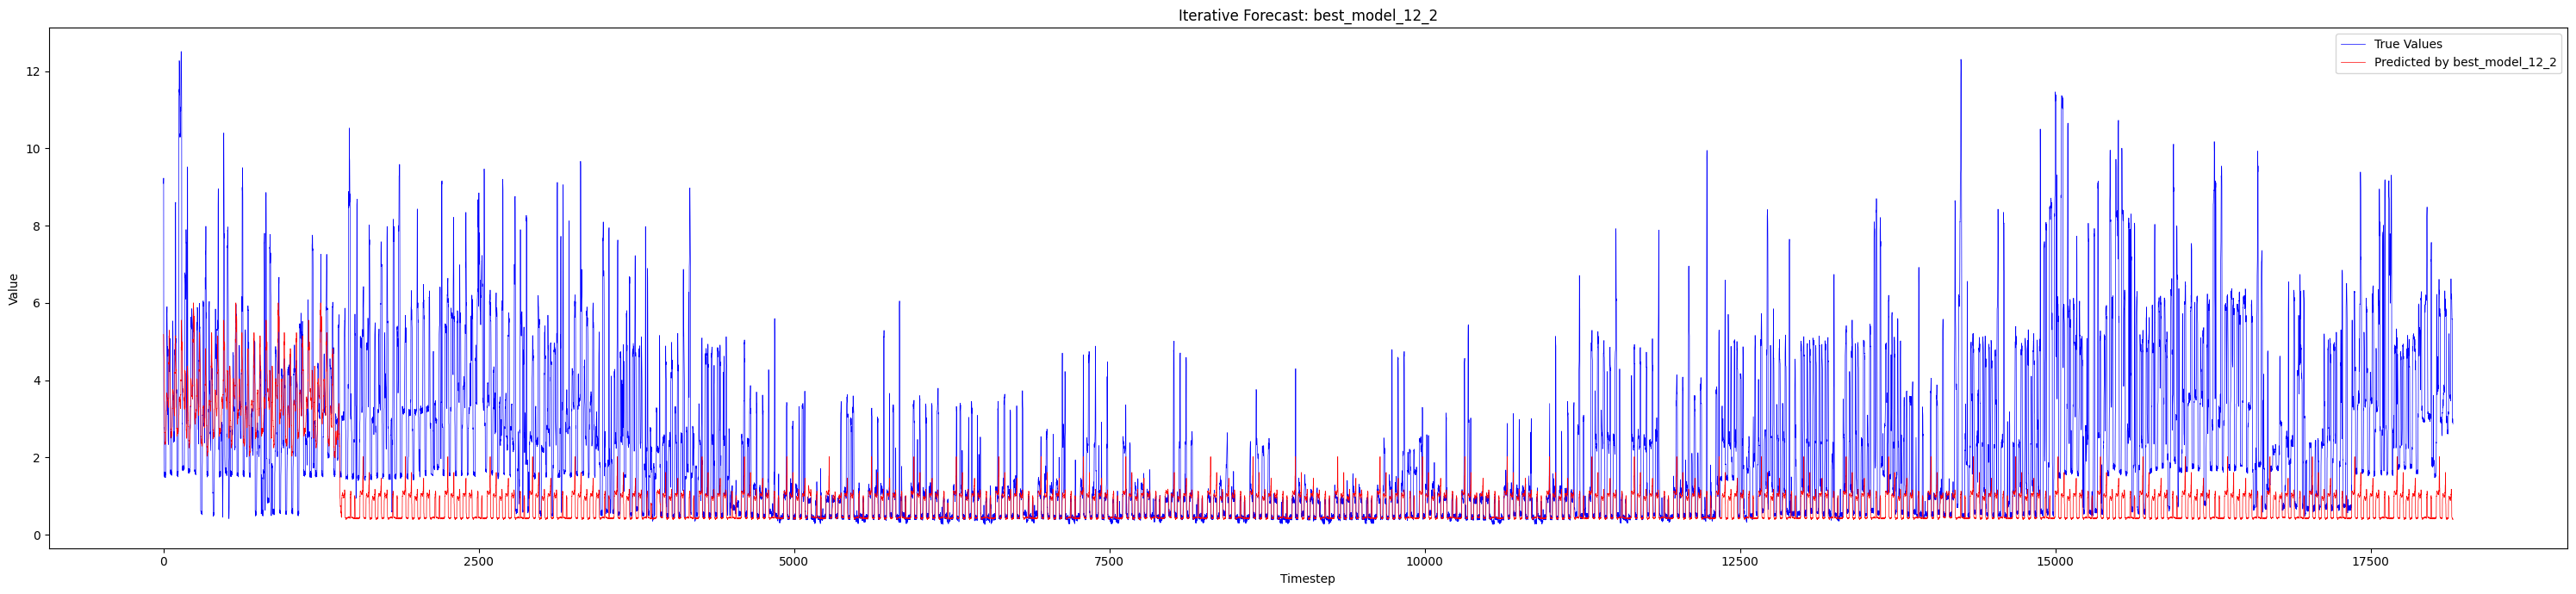

📊 Evaluation Metrics:
MAE:  1.4527
RMSE: 2.2182
MAPE: 64.75%
✅ Loaded model: best_model_12_6 with window=12, horizon=6
🔁 Running iterative forecast for best_model_12_6 with input_window=12, forecast_horizon=6


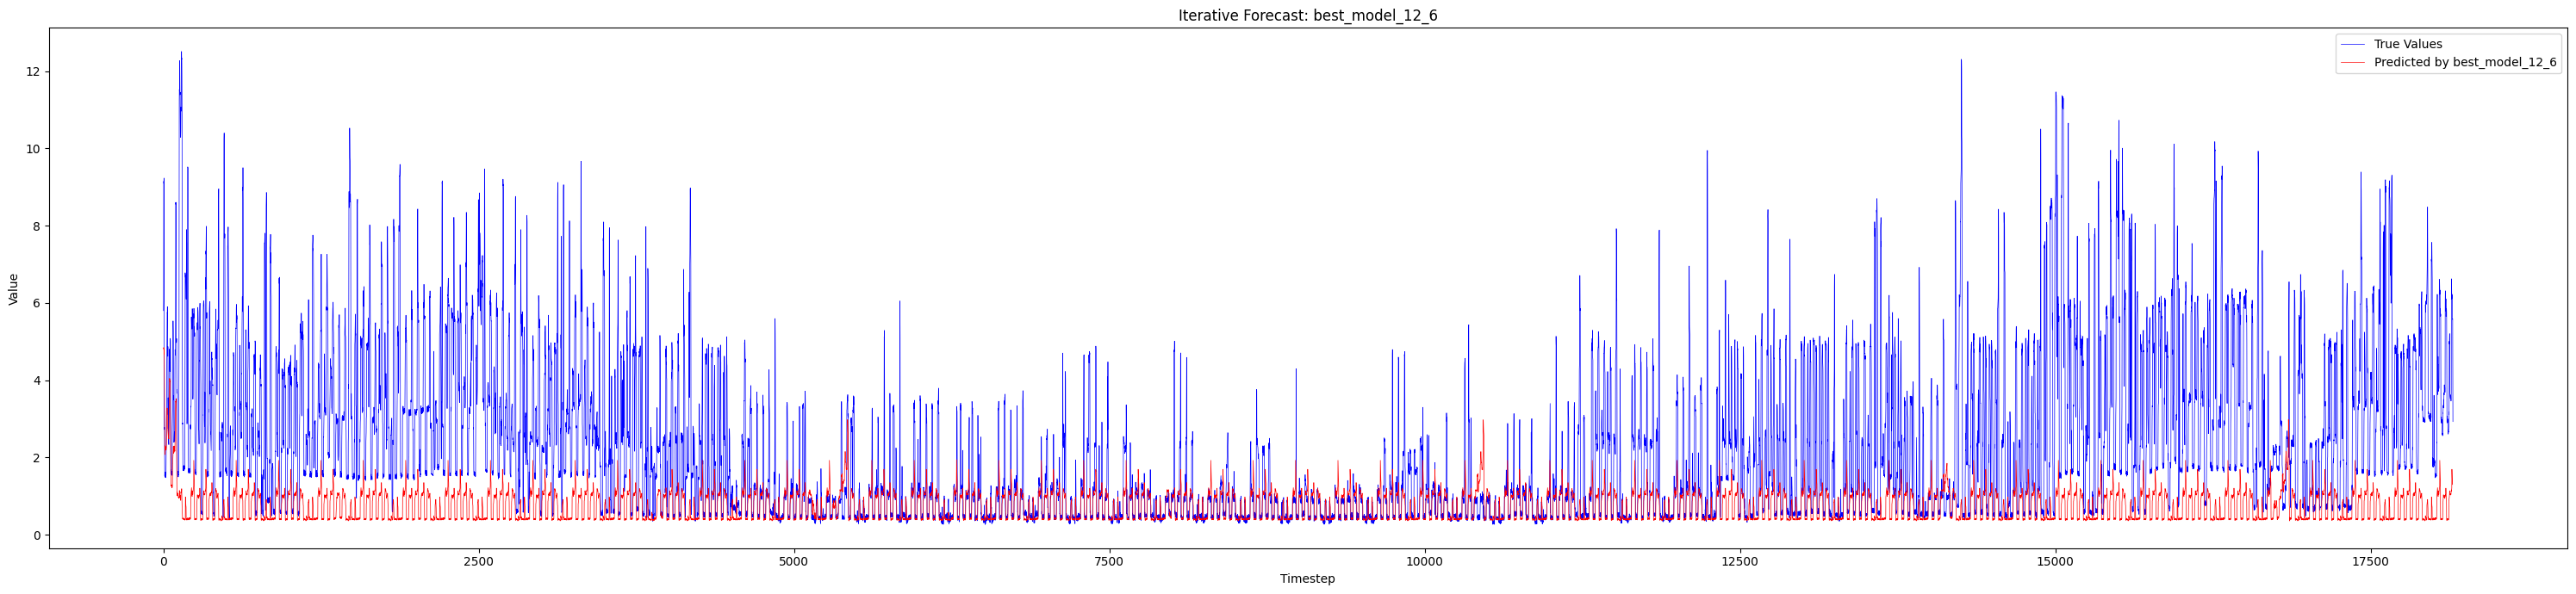

📊 Evaluation Metrics:
MAE:  2.8161
RMSE: 3.5022
MAPE: 73.00%
✅ Loaded model: best_model_2_1 with window=2, horizon=1
🔁 Running iterative forecast for best_model_2_1 with input_window=2, forecast_horizon=1


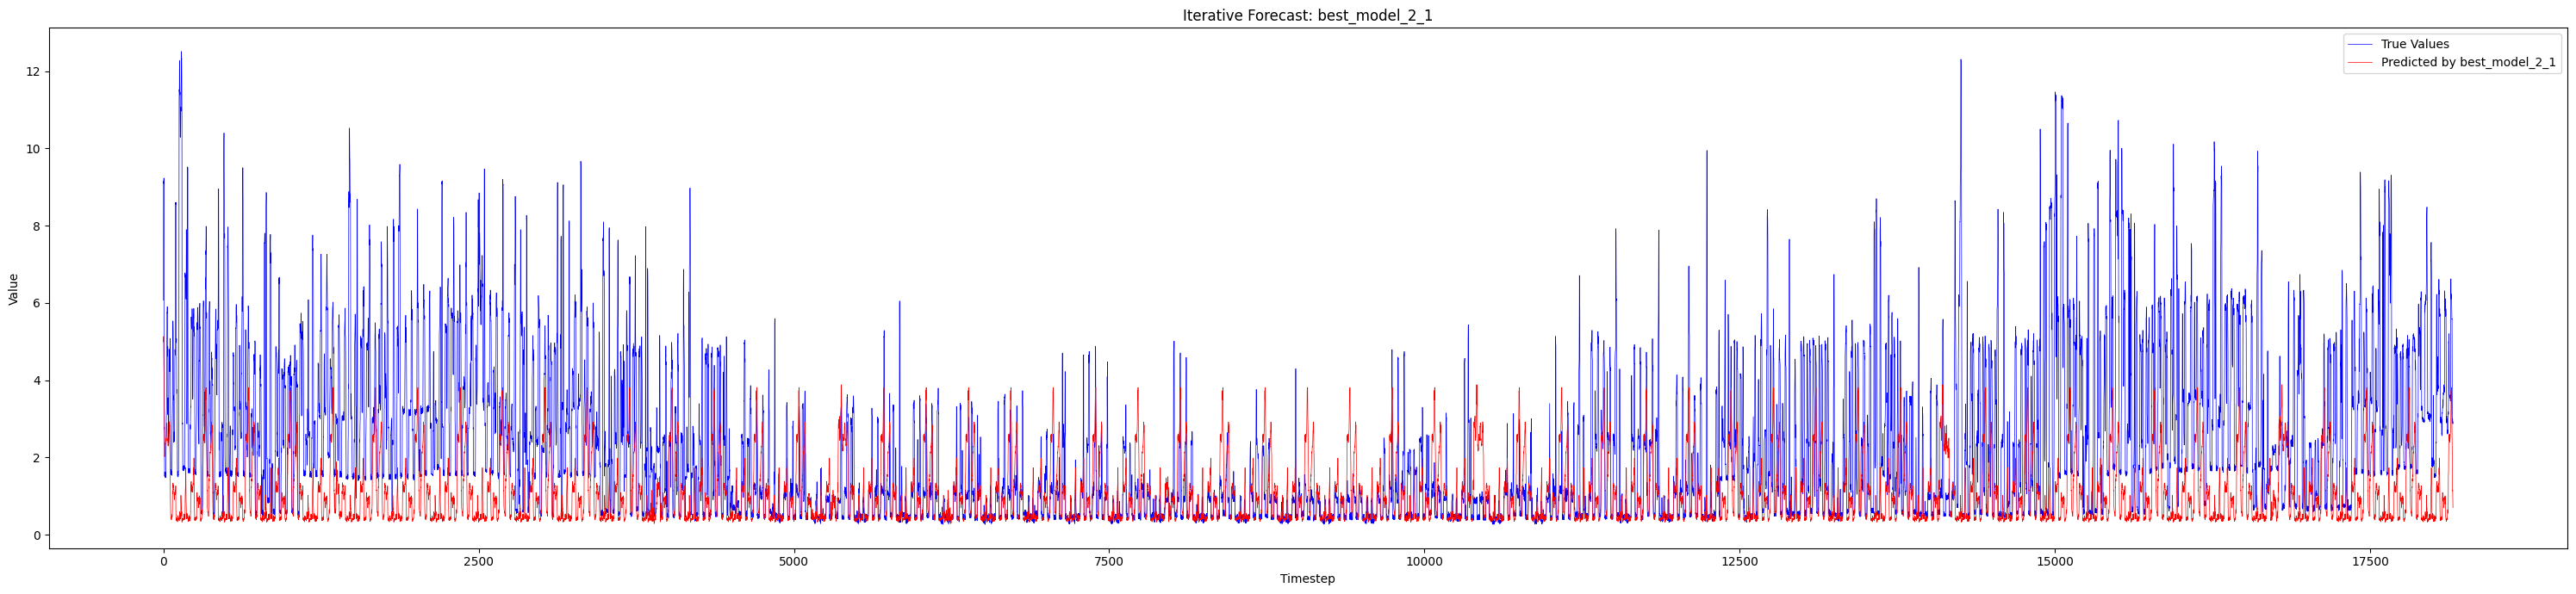

📊 Evaluation Metrics:
MAE:  1.4407
RMSE: 2.2715
MAPE: 57.82%
✅ Loaded model: best_model_2_2 with window=2, horizon=2
🔁 Running iterative forecast for best_model_2_2 with input_window=2, forecast_horizon=2


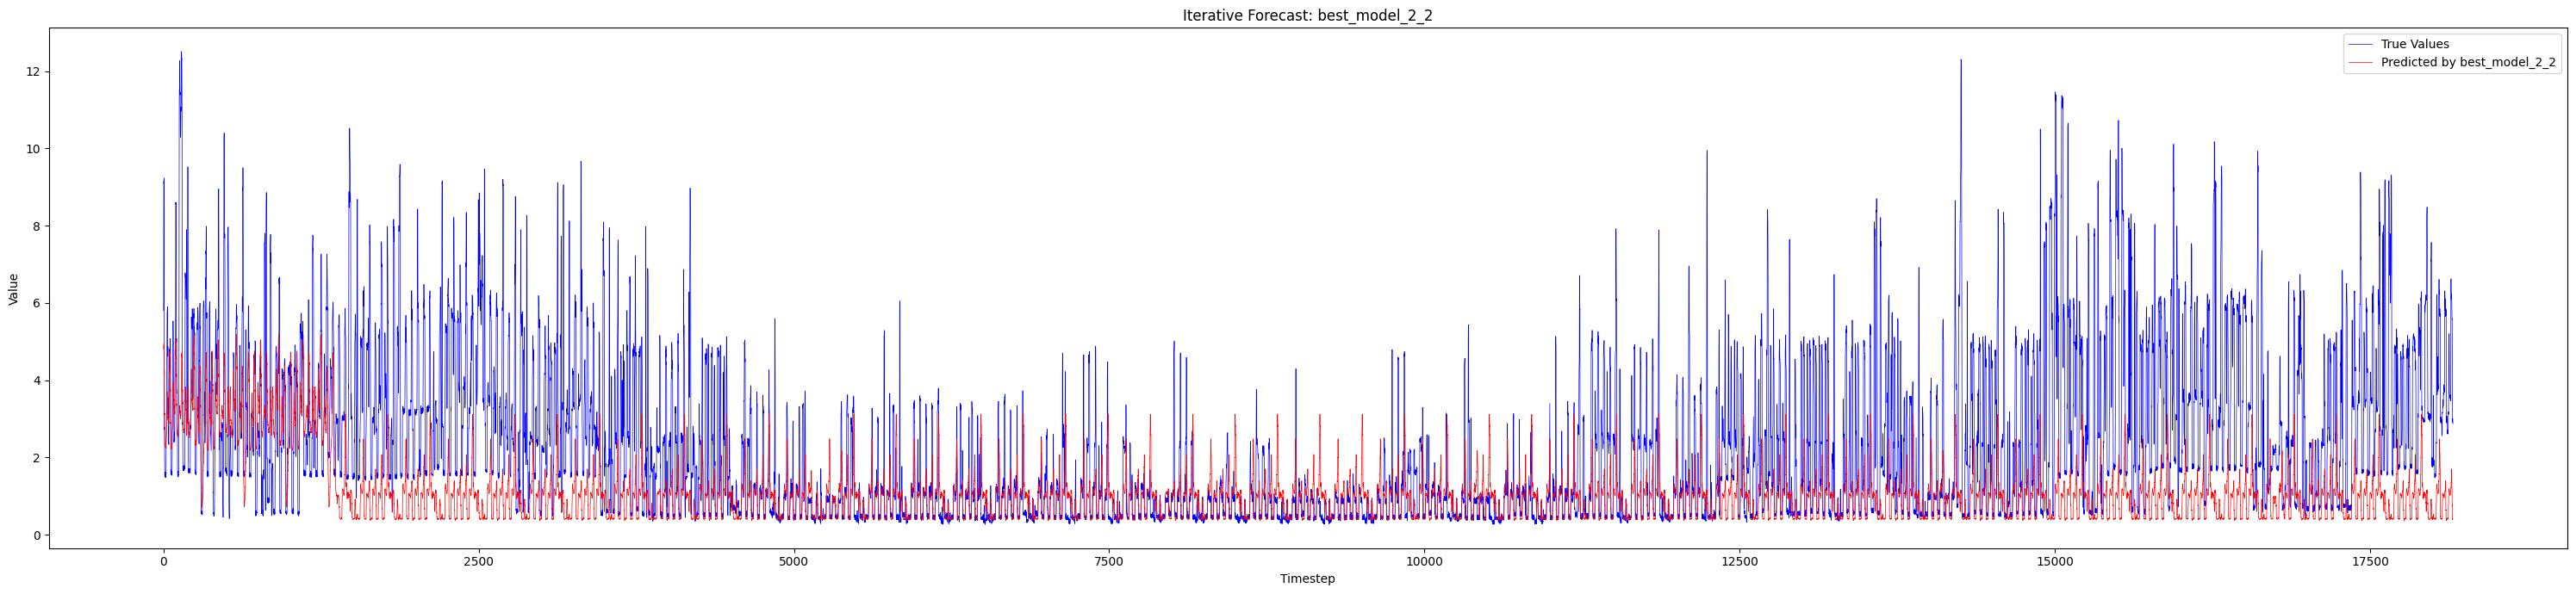

📊 Evaluation Metrics:
MAE:  1.4338
RMSE: 2.1612
MAPE: 73.57%
✅ Loaded model: best_model_2_6 with window=2, horizon=6
🔁 Running iterative forecast for best_model_2_6 with input_window=2, forecast_horizon=6


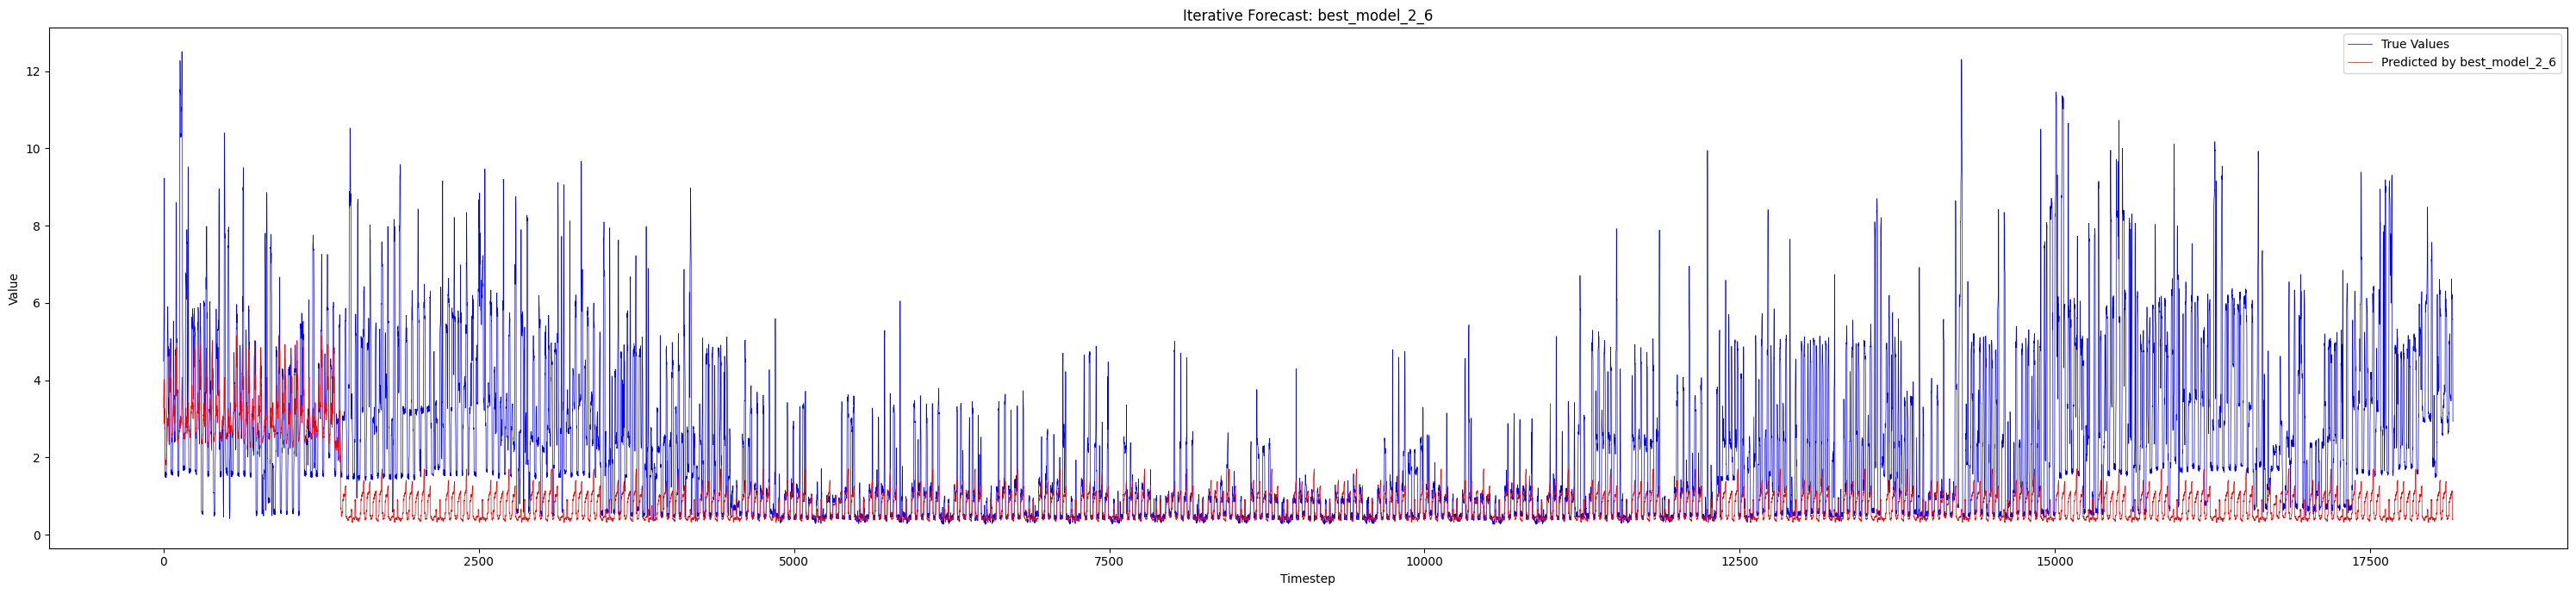

📊 Evaluation Metrics:
MAE:  2.7557
RMSE: 3.4039
MAPE: 72.33%
✅ Loaded model: best_model_6_1 with window=6, horizon=1
🔁 Running iterative forecast for best_model_6_1 with input_window=6, forecast_horizon=1


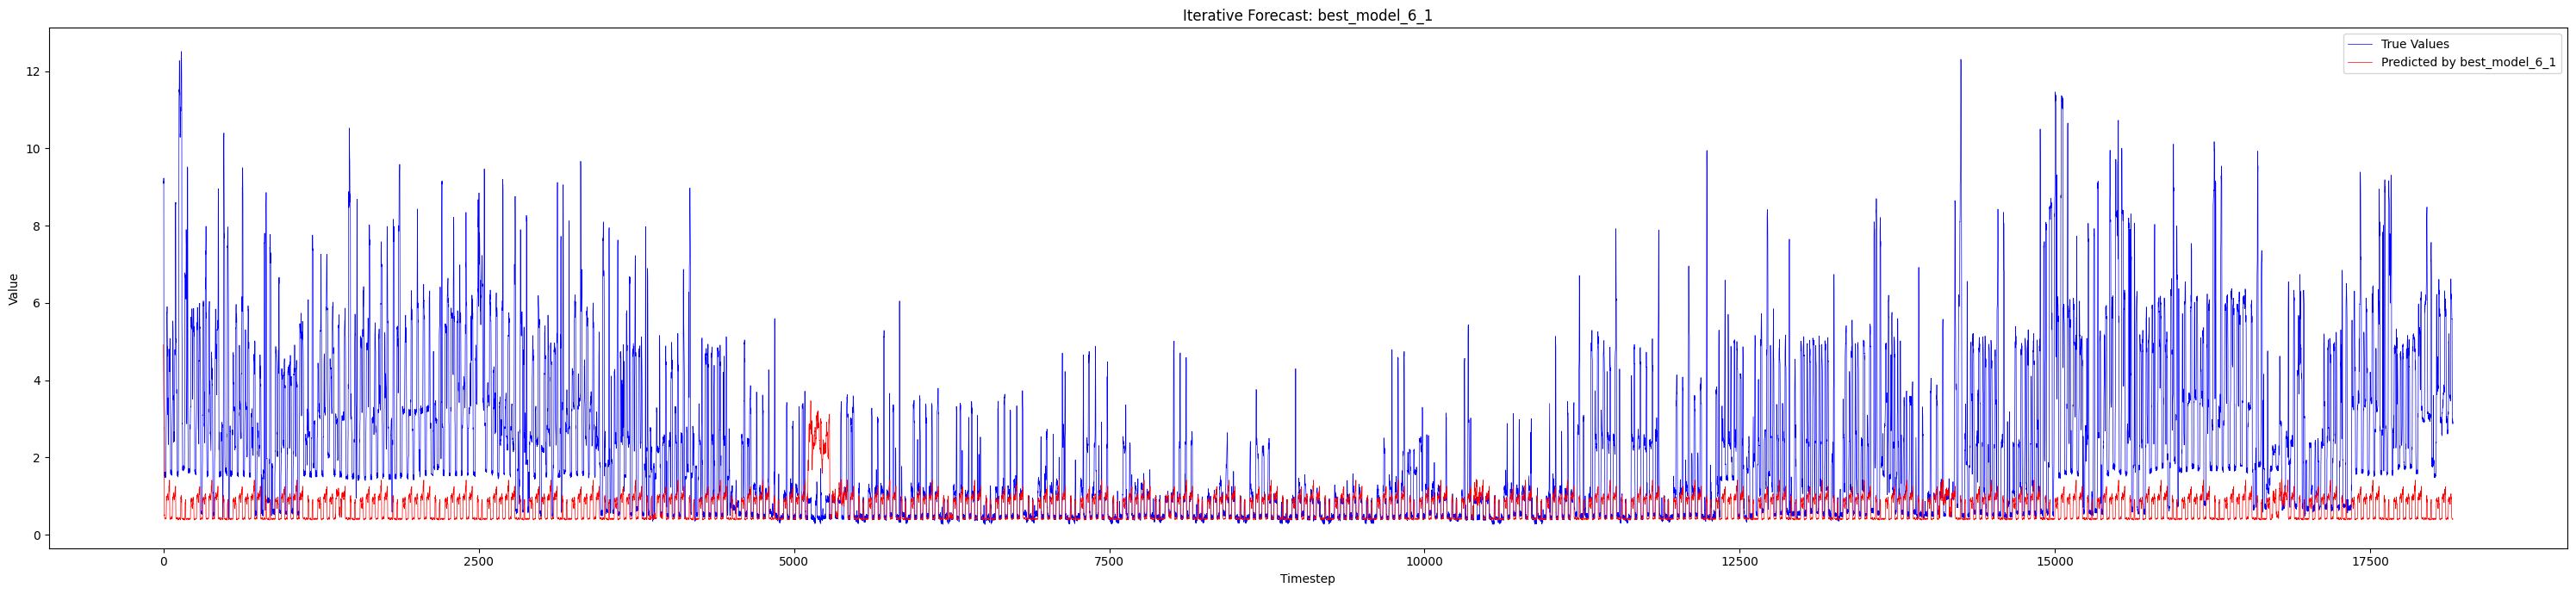

📊 Evaluation Metrics:
MAE:  1.5630
RMSE: 2.4674
MAPE: 52.20%
✅ Loaded model: best_model_6_2 with window=6, horizon=2
🔁 Running iterative forecast for best_model_6_2 with input_window=6, forecast_horizon=2


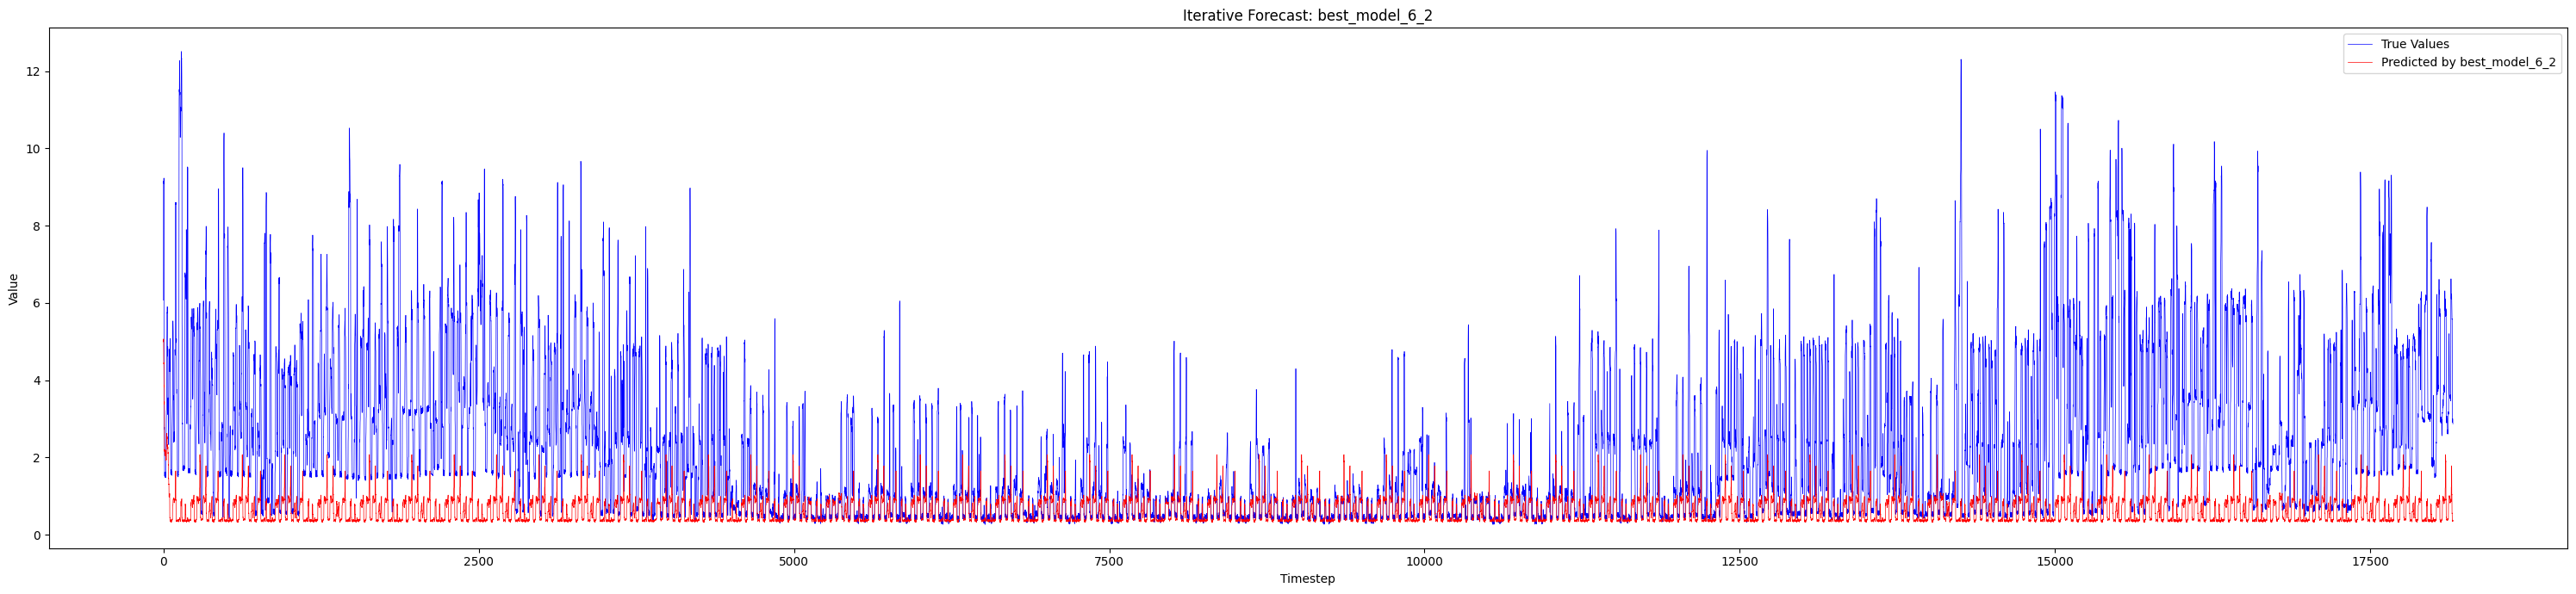

📊 Evaluation Metrics:
MAE:  1.5852
RMSE: 2.4271
MAPE: 62.89%
✅ Loaded model: best_model_6_6 with window=6, horizon=6
🔁 Running iterative forecast for best_model_6_6 with input_window=6, forecast_horizon=6


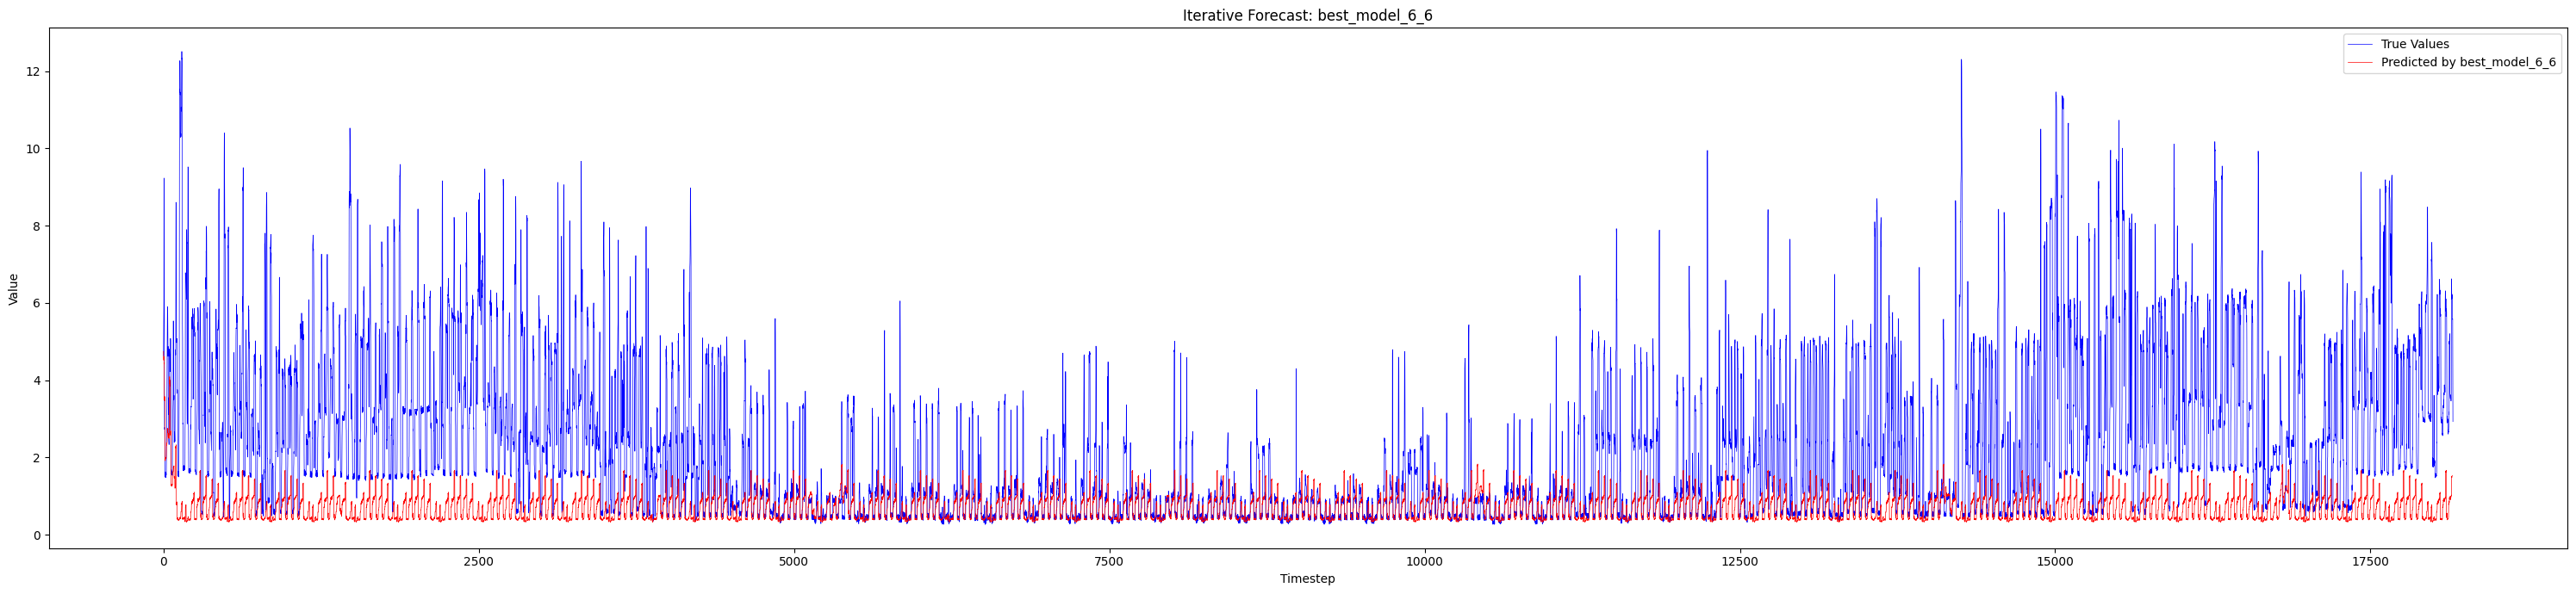

📊 Evaluation Metrics:
MAE:  2.8530
RMSE: 3.5308
MAPE: 73.83%


In [13]:
import os

model_dir = 'models'
results = []
for fname in os.listdir(model_dir):
#for fname in ['best_model_12_6.h5']:
    if not fname.endswith('.h5'):
        continue

    model_path = os.path.join(model_dir, fname)
    model_name = os.path.splitext(fname)[0]
    
    try:
        input_window, forecast_horizon = parse_model_name(model_name)
        model = tf.keras.models.load_model(model_path)
        print(f"✅ Loaded model: {model_name} with window={input_window}, horizon={forecast_horizon}")
    except Exception as e:
        print(f"⚠️ Failed to load {fname}: {e}")
        continue

    # Prepare data
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_sequences(
        df, input_window=input_window, forecast_horizon=forecast_horizon,
        val_ratio=0.1, test_ratio=0.3
    )

    # Use last training input to roll forward
    initial_input = X_val[-1:].copy()  # shape: [1, window, 1]
    total_steps = len(X_test)

    print(f"🔁 Running iterative forecast for {model_name} with input_window={input_window}, forecast_horizon={forecast_horizon}")

    true_rescaled = scaler.inverse_transform(y_test[:, :forecast_horizon])
    preds_rescaled = horizon_rolling_forecast(
        model=model,
        initial_input=initial_input,
        X_test=X_test,
        forecast_horizon=forecast_horizon,
        input_window=input_window,
        scaler=scaler
    )

    plot_iterative(true_rescaled[:, 0], preds_rescaled, model_name)

    # Flatten y_true from shape (n, horizon) -> (n * horizon,)
    true_flat = true_rescaled.reshape(-1)[:len(preds_rescaled)]
    preds_flat = preds_rescaled.reshape(-1)

    # Evaluation
    mae = mean_absolute_error(true_flat, preds_flat)
    rmse = np.sqrt(mean_squared_error(true_flat, preds_flat))
    mape = np.mean(np.abs((true_flat - preds_flat) / (true_flat + 1e-8))) * 100

    results.append({
        "model": model_name,
        "lookback": input_window,
        "lookahead": forecast_horizon,
        "mae": mae,
        "rmse": rmse,
        "mape": mape
    })

    print(f"📊 Evaluation Metrics:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    

In [14]:
results = pd.DataFrame(results)
print("\n✅ Final Results:")
print(results)


✅ Final Results:
             model  lookback  lookahead       mae      rmse       mape
0  best_model_12_1        12          1  1.510872  2.297678  72.558825
1  best_model_12_2        12          2  1.452674  2.218249  64.753525
2  best_model_12_6        12          6  2.816138  3.502190  72.998188
3   best_model_2_1         2          1  1.440666  2.271539  57.820836
4   best_model_2_2         2          2  1.433776  2.161175  73.565489
5   best_model_2_6         2          6  2.755740  3.403900  72.333586
6   best_model_6_1         6          1  1.563012  2.467354  52.202069
7   best_model_6_2         6          2  1.585234  2.427069  62.886502
8   best_model_6_6         6          6  2.853008  3.530814  73.834246


In [15]:
results.to_csv("results_lf.csv", index=False)